## Data Loading

In [3]:
# Step 1: Load and Explore EEG Pain Dataset segments_raw_1000hz_v2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os

# Set dataset root path
root = '/EEG Pain Estimation/data'

# --- Load index.csv ---
index_path = f'{root}/index.csv'
if not os.path.exists(index_path):
    raise FileNotFoundError(f"index.csv not found in {root}")

index_df = pd.read_csv(index_path)
print("Total epochs:", len(index_df))
print(index_df.head())

# --- Check and clean invalid / rejected entries ---
if 'reject_flag' in index_df.columns:
    print(f"Found 'reject_flag' column. Removing rejected epochs...")
    clean_df = index_df[index_df['reject_flag'] == False].copy()
else:
    print("'reject_flag' column not found — using full dataset.")
    clean_df = index_df.copy()

if len(clean_df) == 0:
    print("No valid rows found after filtering. Reverting to full dataset.")
    clean_df = index_df.copy()

print("Clean epochs after filtering:", len(clean_df))

Total epochs: 80282
                               path participant session stimulus_code  \
0   sub-001_ses-1_S18_85554_erp.npz     sub-001   ses-1          S 18   
1  sub-001_ses-1_S18_111637_erp.npz     sub-001   ses-1          S 18   
2  sub-001_ses-1_S18_258152_erp.npz     sub-001   ses-1          S 18   
3  sub-001_ses-1_S18_374867_erp.npz     sub-001   ses-1          S 18   
4  sub-001_ses-1_S18_491584_erp.npz     sub-001   ses-1          S 18   

  stimulus_category  pain_rating rating_bin window   sfreq  n_channels  \
0       Non-painful          0.2       none    erp  1000.0          64   
1       Non-painful          0.1       none    erp  1000.0          64   
2       Non-painful          0.0       none    erp  1000.0          64   
3       Non-painful          0.0       none    erp  1000.0          64   
4       Non-painful          0.3       none    erp  1000.0          64   

   n_times  reject_flag  
0     1001        False  
1     1001        False  
2     1001        

In [11]:
index_df.head()

,path,participant,session,stimulus_code,stimulus_category,pain_rating,rating_bin,window,sfreq,n_channels,n_times,reject_flag
0,sub-001_ses-1_S18_85554_erp.npz,sub-001,ses-1,S 18,Non-painful,0.2,none,erp,1000.0,64,1001,False
1,sub-001_ses-1_S18_111637_erp.npz,sub-001,ses-1,S 18,Non-painful,0.1,none,erp,1000.0,64,1001,False
2,sub-001_ses-1_S18_258152_erp.npz,sub-001,ses-1,S 18,Non-painful,0.0,none,erp,1000.0,64,1001,False
3,sub-001_ses-1_S18_374867_erp.npz,sub-001,ses-1,S 18,Non-painful,0.0,none,erp,1000.0,64,1001,False
4,sub-001_ses-1_S18_491584_erp.npz,sub-001,ses-1,S 18,Non-painful,0.3,none,erp,1000.0,64,1001,False


In [18]:
index_df["window"].unique()

array(['erp', 'post', 'baseline'], dtype=object)

In [12]:
index_df.shape

(80282, 12)

In [4]:
# What does stimulus category mean?
# Unique: ['Non-painful', 'Painful', 'High Pain']
index_df['pain_rating'].unique()

array([ 0.2,  0.1,  0. ,  0.3,  0.4,  1. ,  0.8,  0.7,  1.1,  0.9,  1.5,
        1.6,  1.2,  2.1,  2. ,  5.5,  3.5,  5.7,  5.2,  3.8,  1.9,  3.3,
        5.1,  9.7,  7.7,  7.8,  8.5,  8.6, 10. ,  7. ,  1.3,  1.4,  2.8,
        2.2,  3. ,  4.1,  4.8,  4.3,  5.4,  3.7,  6.2,  9.6,  6.1,  9.3,
        7.2,  8.1,  1.7,  0.5,  1.8,  2.3,  2.5,  2.9,  4.7,  3.2,  6.4,
        6.3,  8.3,  6.7,  8.2,  8. ,  9.9,  8.8,  8.9,  2.4,  4.2,  4.6,
        4.5,  7.1,  9.4,  7.4,  7.3,  5.9,  2.7,  9.1,  9.2,  3.1,  6.8,
        3.4,  6. ,  8.7,  9. ,  2.6,  3.9,  7.5,  7.6,  0.6,  5.8,  4. ,
        3.6,  5.3,  6.5,  8.4,  5.6,  4.4,  4.9,  9.8,  6.9,  5. ,  7.9,
        6.6,  9.5])

## Data Visualization and analysis

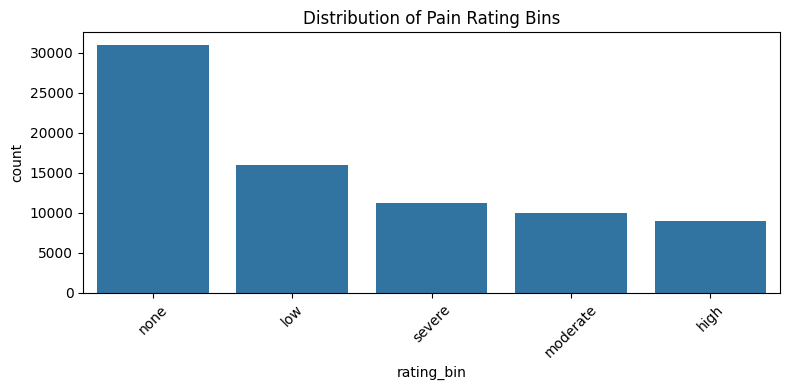

In [5]:
# --- Distribution of pain categories ---
plt.figure(figsize=(8, 4))
sns.countplot(data=clean_df, x='rating_bin', order=clean_df['rating_bin'].value_counts().index)
plt.title("Distribution of Pain Rating Bins")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

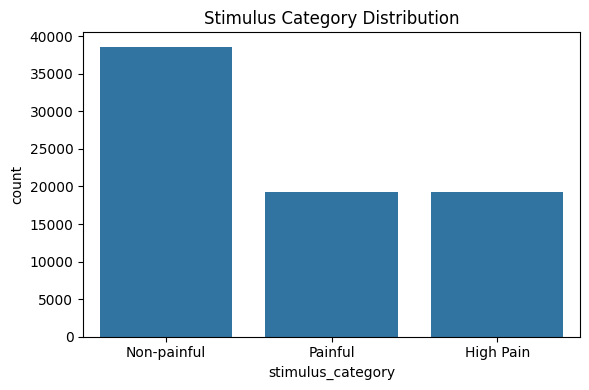

In [6]:
# --- Distribution of stimulus types ---
if 'stimulus_category' in clean_df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=clean_df, x='stimulus_category')
    plt.title("Stimulus Category Distribution")
    plt.tight_layout()
    plt.show()
else:
    print("'stimulus_category' column not found in CSV")


In [7]:

example = clean_df.sample(1, random_state=42).iloc[0]

npz_path = f"{root}/npz/{example['path']}"
if not os.path.exists(npz_path):
    raise FileNotFoundError(f"EEG .npz file not found: {npz_path}")

npz = np.load(npz_path, allow_pickle=True)
X = npz['X']  # shape: (channels, time)
ch_names = npz['ch_names']

print(f"Example EEG shape: {X.shape} (channels × time)")
print(f"Channels available: {len(ch_names)}")

Example EEG shape: (64, 1001) (channels × time)
Channels available: 64


## Data extraction

In [8]:
import os
from tqdm import tqdm
import numpy as np
from scipy.signal import stft
from collections import Counter

fs = 1000
nperseg = 256 
noverlap = 128

def compute_spectrogram(X, fs=1000, nperseg=256, noverlap=128):
    specs = []
    for ch in range(X.shape[0]):
        f, t, Zxx= stft(X[ch], fs=fs, nperseg=nperseg, noverlap=noverlap)
        specs.append(np.abs(Zxx))
    return np.stack(specs, axis=0)

features, labels, ch_counts = [], [], []

# Pass 1 — find most common channel count
for i, row in tqdm(clean_df.iterrows(), total=len(clean_df), desc="Scanning channels"):
    npz_path = os.path.join(root, 'npz', row['path'])
    if not os.path.exists(npz_path):
        continue
    npz = np.load(npz_path, allow_pickle=True)
    ch_counts.append(npz['X'].shape[0])

most_common_channels = Counter(ch_counts).most_common(1)[0][0]
print(f"Most common channel count: {most_common_channels}")

# Pass 2 — extract features only from those epochs
for i, row in tqdm(clean_df.iterrows(), total=len(clean_df), desc="Extracting features"):
    npz_path = os.path.join(root, 'npz', row['path'])
    if not os.path.exists(npz_path):
        continue
    npz = np.load(npz_path, allow_pickle=True)
    X = npz['X']

    # Skip files with mismatched channel count
    if X.shape[0] != most_common_channels:
        continue

    spec = compute_spectrogram(X, fs, nperseg, noverlap)
    mean_feat = np.mean(spec, axis=(1, 2))
    std_feat = np.std(spec, axis=(1, 2))
    feat = np.concatenate([mean_feat, std_feat])
    features.append(feat)
    labels.append(row['rating_bin'])

# Convert to arrays safely
X_features = np.vstack(features)
y_labels = np.array(labels)

print(" Feature matrix shape:", X_features.shape)
print(" Labels:", np.unique(y_labels, return_counts=True))

Scanning channels: 100%|██████████| 77190/77190 [02:30<00:00, 513.39it/s]


Most common channel count: 64


Extracting features: 100%|██████████| 77190/77190 [06:16<00:00, 204.86it/s]

 Feature matrix shape: (75700, 128)
 Labels: (array(['high', 'low', 'moderate', 'none', 'severe'], dtype='<U8'), array([ 8776, 15687,  9835, 30391, 11011]))


## Train Classical Models

In [9]:
# STEP 4: Train and Evaluate ML Models-
# 70-10-20
# Subject level separation splitting also.
# Regression first - ML (Binary - remove none) - Pain/Non pain
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Encode Labels (convert text to numeric)
le = LabelEncoder()
y_labels_enc = le.fit_transform(y_labels)

print("Encoded label mapping:")
for i, cls in enumerate(le.classes_):
    print(f"  {i}: {cls}")

# Handle class imbalance using SMOTE (optional)
print("\nApplying SMOTE to balance classes...")
sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X_features, y_labels_enc)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define models
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=200, max_depth=20, random_state=42, n_jobs=-1
    ),
    "SVM": SVC(kernel="rbf", C=2, gamma="scale"),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    ),
}

# Train and evaluate
for name, model in models.items():
    print(f"\n Training {name} ...")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # Convert numeric predictions back to string labels for readability
    y_true = le.inverse_transform(y_test)
    y_pred = le.inverse_transform(preds)
 
    print(f"\n Results for {name}:")
    print(classification_report(y_true, y_pred, digits=3))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

Encoded label mapping:
  0: high
  1: low
  2: moderate
  3: none
  4: severe

Applying SMOTE to balance classes...

 Training RandomForest ...

 Results for RandomForest:
              precision    recall  f1-score   support

        high      0.784     0.828     0.805      6078
         low      0.682     0.659     0.670      6078
    moderate      0.720     0.811     0.763      6078
        none      0.576     0.475     0.521      6079
      severe      0.765     0.785     0.775      6078

    accuracy                          0.712     30391
   macro avg      0.705     0.712     0.707     30391
weighted avg      0.705     0.712     0.707     30391

Confusion Matrix:
[[5030  247  256  296  249]
 [ 316 4005  469  948  340]
 [ 221  232 4930  447  248]
 [ 560 1109  892 2888  630]
 [ 286  279  302  437 4774]]

 Training SVM ...

 Results for SVM:
              precision    recall  f1-score   support

        high      0.290     0.357     0.320      6078
         low      0.333     0.175

In [10]:
"""
train_ds = EEGDataset(meta_df.sample(2000, random_state=42), root=ROOT, label_encoder=le_full)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

for X, y in train_loader:
    print("Batch X:", X.shape)  # Expect [32, 64, 1001]
    print("Batch y:", y.shape)
    break
"""

'\ntrain_ds = EEGDataset(meta_df.sample(2000, random_state=42), root=ROOT, label_encoder=le_full)\ntrain_loader = DataLoader(train_ds, batch_size=32, shuffle=True)\n\nfor X, y in train_loader:\n    print("Batch X:", X.shape)  # Expect [32, 64, 1001]\n    print("Batch y:", y.shape)\n    break\n'

In [ ]:
#!/usr/bin/env python3
"""
Deep Learning Models Training with Grid Search for 1000 Hz EEG Data

This script trains multiple deep learning models on the original 1000 Hz EEG dataset
with comprehensive hyperparameter grid search to find optimal parameters for each model.
All models are trained with full reproducibility using random seeds.

Author: DILANJAN DK
Email: DDIYABAL@UWO.CA

Models Included:
    - CNN2D: 2D Convolutional Neural Network
    - LSTM: Bidirectional Long Short-Term Memory
    - Transformer: Transformer Encoder
    - CNN-Transformer: Hybrid CNN-Transformer architecture
    - DeepCNN-LSTM: Deep CNN followed by LSTM

Usage Examples:
    # Train all models with grid search on none_vs_pain task
    python scripts/dl_train_1000hz_gridsearch.py --task none_vs_pain

    # Train specific models with grid search
    python scripts/dl_train_1000hz_gridsearch.py --task none_vs_pain --models cnn lstm transformer

    # Train without grid search (use best known parameters)
    python scripts/dl_train_1000hz_gridsearch.py --task none_vs_pain --no-grid-search

    # Custom seed for reproducibility
    python scripts/dl_train_1000hz_gridsearch.py --task none_vs_pain --seed 123

    # Quick test run with fewer samples
    python scripts/dl_train_1000hz_gridsearch.py --task none_vs_pain --quick --quick_n_per_subj 50

Output:
    - Results printed to console with detailed metrics
    - Results saved to JSON file (default: results_1000hz_gridsearch.json)
    - Includes accuracy, balanced accuracy, F1, precision, recall, confusion matrices
    - Best hyperparameters for each model are saved
"""

import os
import sys
import argparse
import json
import random
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from typing import Tuple, Dict, Any, List
from collections import Counter
from itertools import product
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score
from sklearn.model_selection import GroupShuffleSplit, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import pickle
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
# ============================================================================
# REPRODUCIBILITY SETUP
# ============================================================================

def set_seed(seed: int = 42) -> None:
    """
    Set all random seeds for full reproducibility.
    
    This function ensures that all random number generators (Python, NumPy, PyTorch, CUDA)
    are seeded consistently to enable reproducible results across runs.
    
    Args:
        seed: Random seed value (default: 42)
    
    Note:
        Setting deterministic=True for CuDNN may reduce performance but ensures reproducibility.
        This is essential for scientific reproducibility.
    """
    # Python random module
    random.seed(seed)
    
    # NumPy random number generator
    np.random.seed(seed)
    
    # PyTorch random number generators
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    
    # PyTorch deterministic operations
    # Note: This may reduce performance but ensures reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Set environment variable for additional reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    print(f"✓ Random seed set to {seed} for reproducibility")
    print(f"  - Python random: {seed}")
    print(f"  - NumPy random: {seed}")
    print(f"  - PyTorch random: {seed}")
    print(f"  - CUDA deterministic: True")
    print(f"  - CuDNN deterministic: True")

# ==================================================================
# DATA LOADING
# ==================================================================
def find_data_root(proj_root: str, dataset_name: str = 'Data') -> str:
    """
    Find the data root directory for the specified dataset.
    
    Args:
        proj_root: Project root directory
        dataset_name: Name of the dataset directory (default: 'Data' for 1000 Hz)
    
    Returns:
        Path to the data root directory
    """
    candidate = os.path.join(proj_root, dataset_name)
    return candidate if os.path.isdir(candidate) else proj_root

def load_index(root: str) -> pd.DataFrame:
    """
    Load index.csv file containing metadata about EEG segments.
    
    Args:
        root: Root directory containing index.csv
    
    Returns:
        DataFrame with metadata, filtered to exclude rejected epochs
    
    Raises:
        FileNotFoundError: If index.csv is not found
    """
    index_path = os.path.join(root, '/home/asatsan2/Projects/EEG-Pain-Estimation/data/index.csv')
    if not os.path.exists(index_path):
        raise FileNotFoundError(f"index.csv not found at {index_path}")
    
    df = pd.read_csv(index_path)
    
    # Filter out rejected epochs if reject_flag column exists
    if 'reject_flag' in df.columns:
        df = df[df['reject_flag'] == False].copy()
        print(f"  Filtered out rejected epochs: {len(pd.read_csv(index_path)) - len(df)} samples removed")
    
    return df

def get_most_common_channels(df: pd.DataFrame) -> int:
    """
    Get the most common number of channels in the dataset.
    
    Args:
        df: DataFrame with n_channels column
    
    Returns:
        Most common number of channels (default: 64 if not found)
    """
    if 'n_channels' in df.columns:
        cnt = Counter(df['n_channels'].dropna().astype(int))
        return cnt.most_common(1)[0][0] if cnt else 64
    return 64

class EEGDataset(Dataset):
    """
    Dataset for loading EEG segments from NPZ files.
    
    This dataset handles:
    - Channel padding/truncation to a common number of channels
    - Per-channel Z-score normalization
    - Loading from NPZ files stored in the npz directory
    """
    
    def __init__(self, df: pd.DataFrame, root: str, most_ch: int):
        """
        Initialize EEG dataset.
        
        Args:
            df: DataFrame with metadata (must have 'npz_file' or 'path' column)
            root: Root directory containing npz subdirectory
            most_ch: Target number of channels (for padding/truncation)
        """
        self.df = df.reset_index(drop=True)
        self.root = root
        self.most_ch = most_ch
    
    def __len__(self) -> int:
        """Return number of samples in dataset."""
        return len(self.df)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        """
        Load and preprocess a single EEG segment.
        
        Args:
            idx: Index of the sample to load
        
        Returns:
            Tuple of (preprocessed EEG tensor, dummy label)
            EEG tensor shape: (channels, time_points)
        """
        row = self.df.iloc[idx]
        
        # Handle both 'npz_file' and 'path' column names
        npz_file = row.get('npz_file', row.get('path', ''))
        npz_path = os.path.join(self.root, 'npz', npz_file)
        
        # Load EEG data from NPZ file
        with np.load(npz_path, allow_pickle=True) as data:
            X = data['X']  # Shape: (channels, time)
            
        # Pad or truncate channels to most_common_channels
        ch, T = X.shape
        if ch < self.most_ch:
            pad = np.zeros((self.most_ch - ch, T), dtype=X.dtype)
            X = np.vstack([X, pad])
        elif ch > self.most_ch:
            X = X[:self.most_ch, :]
        
        # Z-score normalization per channel
        mean = X.mean(axis=1, keepdims=True)
        std = X.std(axis=1, keepdims=True) + 1e-8
        X = (X - mean) / std
        
        return torch.FloatTensor(X), 0  # dummy label

def load_task_data(df: pd.DataFrame, task: str) -> Tuple[np.ndarray, LabelEncoder, pd.DataFrame]:
    """
    Prepare labels for a given classification task.
    
    Args:
        df: DataFrame with rating_bin column
        task: Task name ('pain_5class', 'none_vs_pain', 'pain_only', 'pain_threshold')
    
    Returns:
        Tuple of (encoded labels, label encoder, filtered dataframe)
    
    Raises:
        ValueError: If task is unknown or no samples found
    """
    le = LabelEncoder()
    
    if task == 'pain_5class':
        y = le.fit_transform(df['rating_bin'])
    elif task == 'none_vs_pain':
        df = df.copy()
        df['binary'] = df['rating_bin'].apply(lambda x: 'none' if x == 'none' else 'pain')
        y = le.fit_transform(df['binary'])
    elif task == 'pain_only':
        pain_df = df[df['rating_bin'] != 'none'].copy()
        if len(pain_df) == 0:
            raise ValueError("No pain samples found")
        y = le.fit_transform(pain_df['rating_bin'])
        df = pain_df
    elif task == 'pain_threshold':
        # Binary: no_significant_pain (none+low) vs significant_pain (moderate+high+severe)
        df = df.copy()
        def threshold_label(rating_bin):
            if rating_bin in ['none', 'low']:
                return 'no_significant_pain'
            else:
                return 'significant_pain'
        df['threshold_label'] = df['rating_bin'].apply(threshold_label)
        y = le.fit_transform(df['threshold_label'])
    else:
        raise ValueError(f"Unknown task: {task}")
    
    return y, le, df

def load_all_segments(df: pd.DataFrame, root: str, most_ch: int) -> torch.Tensor:
    """
    Load all EEG segments into memory for faster training.
    
    Args:
        df: DataFrame with metadata
        root: Root directory containing npz subdirectory
        most_ch: Target number of channels
    
    Returns:
        Tensor of shape (n_samples, n_channels, n_time_points)
    """
    print(f"\n{'='*70}")
    print(" DATA LOADING")
    print(f"{'='*70}")
    print(f"Total samples to load: {len(df):,}")
    print(f"Most common channels: {most_ch}")
    print(f"NPZ directory: {os.path.join(root, 'npz')}")
    
    # Update df with npz_file column if needed
    if 'npz_file' not in df.columns and 'path' in df.columns:
        df = df.copy()
        df['npz_file'] = df['path']
        print("Using 'path' column as 'npz_file'")
    else:
        print("Using 'npz_file' column")
    
    # Check channel distribution
    if 'n_channels' in df.columns:
        ch_counts = Counter(df['n_channels'].dropna().astype(int))
        print(f"\nChannel distribution:")
        for ch, count in sorted(ch_counts.items())[:10]:
            print(f"  {ch} channels: {count:,} samples")
        if len(ch_counts) > 10:
            print(f"  ... and {len(ch_counts) - 10} more channel configurations")
    
    dataset = EEGDataset(df, root, most_ch)
    loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
    
    all_X = []
    print(f"\nLoading segments in batches of 32...")
    for batch_idx, (xb, _) in enumerate(tqdm(loader, desc="Loading segments", unit="batch")):
        all_X.append(xb)
        if batch_idx == 0:
            print(f"  First batch shape: {xb.shape}")
    
    X_tensor = torch.cat(all_X, dim=0)
    print(f"\n✓ Successfully loaded {X_tensor.shape[0]:,} segments")
    print(f"  Shape: (samples={X_tensor.shape[0]}, channels={X_tensor.shape[1]}, time_points={X_tensor.shape[2]})")
    print(f"  Memory usage: ~{X_tensor.numel() * 4 / 1024**2:.2f} MB (float32)")
    return X_tensor

# ============================================================================
# MODEL ARCHITECTURES
# ============================================================================

class CNN2D(nn.Module):
    """
    2D Convolutional Neural Network for EEG classification.
    
    Architecture:
        - 3 convolutional layers with increasing filters (32→64→128)
        - Batch normalization and max pooling
        - Adaptive average pooling for variable input sizes
        - Dropout and fully connected layer for classification
    """
    
    def __init__(self, n_channels: int, n_time: int, n_classes: int, dropout: float = 0.5):
        """
        Initialize CNN2D model.
        
        Args:
            n_channels: Number of EEG channels
            n_time: Number of time points
            n_classes: Number of output classes
            dropout: Dropout probability
        """
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(n_channels//8, 7), padding=(0, 3))
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d((1, 4))
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(1, 5), padding=(0, 2))
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d((1, 4))
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(1, 3), padding=(0, 1))
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.AdaptiveAvgPool2d((1, 1))
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(128, n_classes)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.
        
        Args:
            x: Input tensor of shape (batch, channels, time)
        
        Returns:
            Output logits of shape (batch, n_classes)
        """
        x = x.unsqueeze(1)  # (batch, 1, channels, time)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)

class LSTMModel(nn.Module):
    """
    Bidirectional LSTM model for EEG classification.
    
    Architecture:
        - Multi-layer bidirectional LSTM
        - Dropout for regularization
        - Fully connected layer for classification
    """
    
    def __init__(self, n_channels: int, n_classes: int, hidden: int = 128, 
                 dropout: float = 0.5, bidirectional: bool = True):
        """
        Initialize LSTM model.
        
        Args:
            n_channels: Number of EEG channels (input features)
            n_classes: Number of output classes
            hidden: Hidden state size
            dropout: Dropout probability
            bidirectional: Whether to use bidirectional LSTM
        """
        super().__init__()
        self.lstm = nn.LSTM(n_channels, hidden, batch_first=True, num_layers=2, 
                           dropout=dropout if dropout > 0 else 0, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout)
        fc_in = hidden * 2 if bidirectional else hidden
        self.fc = nn.Linear(fc_in, n_classes)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.
        
        Args:
            x: Input tensor of shape (batch, channels, time)
        
        Returns:
            Output logits of shape (batch, n_classes)
        """
        x = x.transpose(1, 2)  # (batch, time, channels)
        _, (h, _) = self.lstm(x)
        if self.lstm.bidirectional:
            h = torch.cat([h[-2], h[-1]], dim=1)
        else:
            h = h[-1]
        h = self.dropout(h)
        return self.fc(h)

class TransformerModel(nn.Module):
    """
    Transformer encoder model for EEG classification.
    
    Architecture:
        - Input downsampling and projection
        - Positional encoding
        - Multi-layer Transformer encoder
        - Global average pooling and classification
    """
    
    def __init__(self, n_channels: int, n_time: int, n_classes: int, 
                 d_model: int = 128, nhead: int = 8, num_layers: int = 4, dropout: float = 0.3):
        """
        Initialize Transformer model.
        
        Args:
            n_channels: Number of EEG channels
            n_time: Number of time points
            n_classes: Number of output classes
            d_model: Model dimension
            nhead: Number of attention heads
            num_layers: Number of transformer layers
            dropout: Dropout probability
        """
        super().__init__()
        self.n_channels = n_channels
        self.d_model = d_model
        
        self.downsample = 4
        self.proj = nn.Linear(n_channels * self.downsample, d_model)
        
        max_len = n_time // self.downsample + 1
        self.pos_encoding = nn.Parameter(torch.randn(1, max_len, d_model))
        
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=d_model*4, 
                                                   dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, n_classes)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.
        
        Args:
            x: Input tensor of shape (batch, channels, time)
        
        Returns:
            Output logits of shape (batch, n_classes)
        """
        batch_size, C, T = x.shape
        
        T_down = (T // self.downsample) * self.downsample
        x = x[:, :, :T_down]
        x = x.reshape(batch_size, C, -1, self.downsample)
        x = x.permute(0, 2, 1, 3)
        x = x.reshape(batch_size, T_down // self.downsample, -1)
        
        x = self.proj(x)
        
        seq_len = x.size(1)
        x = x + self.pos_encoding[:, :seq_len, :]
        
        x = self.transformer(x)
        
        x = x.mean(dim=1)
        x = self.dropout(x)
        return self.fc(x)

class CNN_Transformer(nn.Module):
    """
    Hybrid CNN-Transformer model for EEG classification.
    
    Architecture:
        - CNN for spatial feature extraction
        - Transformer for temporal attention
        - Combines spatial and temporal modeling
    """
    
    def __init__(self, n_channels: int, n_time: int, n_classes: int,
                 cnn_filters: int = 64, d_model: int = 128, nhead: int = 8, 
                 num_layers: int = 3, dropout: float = 0.3):
        """
        Initialize CNN-Transformer model.
        
        Args:
            n_channels: Number of EEG channels
            n_time: Number of time points
            n_classes: Number of output classes
            cnn_filters: Number of CNN output filters
            d_model: Transformer model dimension
            nhead: Number of attention heads
            num_layers: Number of transformer layers
            dropout: Dropout probability
        """
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(n_channels//8, 1), padding=(0, 0))
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d((2, 1))
        
        self.conv2 = nn.Conv2d(32, cnn_filters, kernel_size=(1, 1))
        self.bn2 = nn.BatchNorm2d(cnn_filters)
        self.pool2 = nn.AdaptiveAvgPool2d((1, n_time // 4))
        
        self.cnn_to_transformer = nn.Linear(cnn_filters, d_model)
        
        max_len = n_time // 4 + 1
        self.pos_encoding = nn.Parameter(torch.randn(1, max_len, d_model))
        
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=d_model*4,
                                                   dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, n_classes)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.
        
        Args:
            x: Input tensor of shape (batch, channels, time)
        
        Returns:
            Output logits of shape (batch, n_classes)
        """
        batch_size = x.size(0)
        
        x = x.unsqueeze(1)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        
        x = x.squeeze(2).transpose(1, 2)
        
        x = self.cnn_to_transformer(x)
        
        seq_len = x.size(1)
        x = x + self.pos_encoding[:, :seq_len, :]
        
        x = self.transformer(x)
        
        x = x.mean(dim=1)
        
        x = self.dropout(x)
        return self.fc(x)

class DeepCNN_LSTM(nn.Module):
    """
    Deep CNN-LSTM model for EEG classification.
    
    Architecture:
        - Deep CNN for hierarchical spatial feature extraction
        - Bidirectional LSTM for temporal modeling
        - Best performing architecture for pain threshold detection
    """
    
    def __init__(self, n_channels: int, n_time: int, n_classes: int = 2,
                 cnn_filters: List[int] = [32, 64, 128], 
                 lstm_hidden: int = 192, 
                 lstm_layers: int = 2,
                 dropout: float = 0.4):
        """
        Initialize DeepCNN-LSTM model.
        
        Args:
            n_channels: Number of EEG channels
            n_time: Number of time points
            n_classes: Number of output classes
            cnn_filters: List of filter sizes for CNN layers
            lstm_hidden: LSTM hidden state size
            lstm_layers: Number of LSTM layers
            dropout: Dropout probability
        """
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, cnn_filters[0], kernel_size=(n_channels//8, 3), padding=(0, 1))
        self.bn1 = nn.BatchNorm2d(cnn_filters[0])
        self.pool1 = nn.MaxPool2d((2, 2))
        
        self.conv2 = nn.Conv2d(cnn_filters[0], cnn_filters[1], kernel_size=(1, 3), padding=(0, 1))
        self.bn2 = nn.BatchNorm2d(cnn_filters[1])
        self.pool2 = nn.MaxPool2d((1, 2))
        
        self.conv3 = nn.Conv2d(cnn_filters[1], cnn_filters[2], kernel_size=(1, 3), padding=(0, 1))
        self.bn3 = nn.BatchNorm2d(cnn_filters[2])
        self.pool3 = nn.MaxPool2d((1, 2))
        
        time_reduced = n_time // 8
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, time_reduced))
        
        self.lstm = nn.LSTM(cnn_filters[2], lstm_hidden, batch_first=True, 
                           num_layers=lstm_layers, dropout=dropout if lstm_layers > 1 else 0, 
                           bidirectional=True)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden * 2, n_classes)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.
        
        Args:
            x: Input tensor of shape (batch, channels, time)
        
        Returns:
            Output logits of shape (batch, n_classes)
        """
        batch_size = x.size(0)
        
        x = x.unsqueeze(1)
        
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        
        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        
        x = self.adaptive_pool(x)
        
        x = x.squeeze(2).transpose(1, 2)
        
        _, (h, _) = self.lstm(x)
        h = torch.cat([h[-2], h[-1]], dim=1)
        
        h = self.dropout(h)
        return self.fc(h)

# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================

def class_weights_from_y(y: np.ndarray, class_names: list = None) -> Tuple[torch.FloatTensor, Dict]:
    """
    Compute class weights for imbalanced datasets.
    
    Args:
        y: Array of class labels
        class_names: List of class names (optional)
    
    Returns:
        Tuple of (class weights tensor, weight information dictionary)
    """
    unique, counts = np.unique(y, return_counts=True)
    weights = len(y) / (len(unique) * counts)
    
    weight_info = {}
    for i, (cls_idx, count) in enumerate(zip(unique, counts)):
        cls_name = class_names[cls_idx] if class_names else f"Class_{cls_idx}"
        weight_info[cls_name] = {
            'count': int(count),
            'weight': float(weights[i]),
            'percentage': float(count / len(y) * 100)
        }
    
    return torch.FloatTensor(weights), weight_info

def train_one_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader,
                    y_train: np.ndarray, device: str, epochs: int = 50, patience: int = 15,
                    lr: float = 1e-3, weight_decay: float = 1e-5, class_names: list = None,
                    model_name: str = "Model", verbose: bool = True) -> Tuple[nn.Module, float, Dict]:
    """
    Train one model with early stopping.
    
    Args:
        model: PyTorch model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        y_train: Training labels (for class weights)
        device: Device to train on ('cuda' or 'cpu')
        epochs: Maximum number of epochs
        patience: Early stopping patience
        lr: Learning rate
        weight_decay: Weight decay for optimizer
        class_names: List of class names (optional)
        model_name: Name of model for logging
        verbose: Whether to print training progress
    
    Returns:
        Tuple of (trained model, best validation F1, training info dictionary)
    """
    if verbose:
        print(f"\n{'='*70}")
        print(f" TRAINING SETUP: {model_name}")
        print(f"{'='*70}")
    
    model.to(device)
    if verbose:
        print(f"Model moved to device: {device}")
    
    # Class weights
    weights, weight_info = class_weights_from_y(y_train, class_names)
    weights = weights.to(device)
    if verbose:
        print(f"\nClass weights for loss function:")
        for cls_name, info in weight_info.items():
            print(f"  {cls_name:20s}: count={info['count']:6d} ({info['percentage']:5.2f}%), weight={info['weight']:.4f}")
    
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=False)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    if verbose:
        print(f"\nOptimizer: Adam")
        print(f"  Learning rate: {lr:.6f}")
        print(f"  Weight decay: {weight_decay:.6f}")
        print(f"  Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)")
        print(f"\nTraining configuration:")
        print(f"  Max epochs: {epochs}")
        print(f"  Early stopping patience: {patience}")
        print(f"  Train batches: {len(train_loader)}")
        print(f"  Validation batches: {len(val_loader)}")
    
    best_state, best_val_loss = None, float('inf')
    best_val_f1 = 0.0
    best_val_acc = 0.0
    best_epoch = 0
    no_improve = 0
    current_lr = lr
    
    if verbose:
        print(f"\n{'='*70}")
        print(f" TRAINING PROGRESS")
        print(f"{'='*70}")
        print(f"{'Epoch':<8} {'Train Loss':<12} {'Val Loss':<12} {'Val Acc':<10} {'Val F1':<10} {'LR':<12} {'Status':<15}")
        print("-" * 70)
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_losses = []
        
        for batch_idx, (xb, yb) in enumerate(train_loader):
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_losses.append(loss.item())
        
        tr_loss = np.mean(train_losses)
        
        # Validation phase
        model.eval()
        val_losses = []
        val_preds, val_targets = [], []
        
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                val_losses.append(loss.item())
                val_preds.append(out.argmax(dim=1).cpu().numpy())
                val_targets.append(yb.cpu().numpy())
        
        vloss = np.mean(val_losses)
        val_preds = np.concatenate(val_preds)
        val_targets = np.concatenate(val_targets)
        val_f1 = f1_score(val_targets, val_preds, average='macro', zero_division=0)
        val_acc = (val_preds == val_targets).mean()
        
        # Learning rate scheduling
        old_lr = current_lr
        scheduler.step(vloss)
        current_lr = optimizer.param_groups[0]['lr']
        lr_changed = abs(current_lr - old_lr) > 1e-8
        
        # Status indicator
        if vloss < best_val_loss - 1e-4:
            status = "✓ New best!"
            best_val_loss = vloss
            best_val_f1 = val_f1
            best_val_acc = val_acc
            best_epoch = epoch + 1
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                status = "⏹ Early stop"
            else:
                status = f"No improve ({no_improve}/{patience})"
        
        # Print every epoch if verbose
        if verbose:
            lr_str = f"{current_lr:.2e}"
            if lr_changed:
                lr_str += " ↓"
            print(f"{epoch+1:<8} {tr_loss:<12.6f} {vloss:<12.6f} {val_acc:<10.4f} {val_f1:<10.4f} {lr_str:<12} {status:<15}")
        
        if no_improve >= patience:
            if verbose:
                print(f"\n⏹ Early stopping triggered at epoch {epoch+1}")
                print(f"   No improvement for {patience} epochs")
            break
    
    # Load best model
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
        if verbose:
            print(f"\n✓ Loaded best model from epoch {best_epoch}")
            print(f"  Best validation loss: {best_val_loss:.6f}")
            print(f"  Best validation accuracy: {best_val_acc:.4f}")
            print(f"  Best validation F1: {best_val_f1:.4f}")
    else:
        if verbose:
            print(f"\n⚠ No best model state saved (using final model)")
    
    training_info = {
        'best_epoch': best_epoch,
        'best_val_loss': float(best_val_loss),
        'best_val_acc': float(best_val_acc),
        'best_val_f1': float(best_val_f1),
        'total_epochs': epoch + 1,
        'early_stopped': no_improve >= patience
    }
    
    return model, best_val_f1, training_info


def create_model_directory(base_path: str, task: str) -> str:
    """Create organized directory structure for saving models."""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_dir = os.path.join(base_path, 'saved_models', task, timestamp)
    os.makedirs(model_dir, exist_ok=True)
    
    # Create subdirectories
    os.makedirs(os.path.join(model_dir, 'deep_learning'), exist_ok=True)
    os.makedirs(os.path.join(model_dir, 'classical_ml'), exist_ok=True)
    os.makedirs(os.path.join(model_dir, 'metadata'), exist_ok=True)
    
    print(f"✓ Created model directory: {model_dir}")
    return model_dir

def save_dl_model(model: nn.Module, model_name: str, save_dir: str, 
                  metadata: Dict, best_params: Dict) -> str:
    """Save deep learning model with metadata."""
    model_path = os.path.join(save_dir, 'deep_learning', f'{model_name}_best.pth')
    
    # Save model state dict
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_architecture': model.__class__.__name__,
        'hyperparameters': best_params,
        'metadata': metadata
    }, model_path)
    
    # Save metadata as JSON
    metadata_path = os.path.join(save_dir, 'metadata', f'{model_name}_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump({
            'model_name': model_name,
            'architecture': model.__class__.__name__,
            'hyperparameters': best_params,
            'training_info': metadata,
            'saved_at': datetime.now().isoformat()
        }, f, indent=2)
    
    print(f"  ✓ Saved DL model: {model_path}")
    return model_path

def save_classical_model(model, model_name: str, save_dir: str, 
                        metadata: Dict, best_params: Dict) -> str:
    """Save classical ML model with metadata."""
    model_path = os.path.join(save_dir, 'classical_ml', f'{model_name}_best.pkl')
    
    # Save model using pickle
    with open(model_path, 'wb') as f:
        pickle.dump({
            'model': model,
            'model_type': model.__class__.__name__,
            'hyperparameters': best_params,
            'metadata': metadata
        }, f)
    
    # Save metadata as JSON
    metadata_path = os.path.join(save_dir, 'metadata', f'{model_name}_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump({
            'model_name': model_name,
            'model_type': model.__class__.__name__,
            'hyperparameters': best_params,
            'training_info': metadata,
            'saved_at': datetime.now().isoformat()
        }, f, indent=2)
    
    print(f"  ✓ Saved Classical ML model: {model_path}")
    return model_path

# ============================================================================
# CLASSICAL ML MODELS
# ============================================================================

def prepare_features_for_classical_ml(X: torch.Tensor) -> np.ndarray:
    """
    Prepare EEG features for classical ML models.
    Flattens (n_samples, n_channels, n_time) to (n_samples, n_channels * n_time)
    """
    if isinstance(X, torch.Tensor):
        X = X.cpu().numpy()
    
    n_samples = X.shape[0]
    X_flat = X.reshape(n_samples, -1)
    
    print(f"  Feature preparation: {X.shape} -> {X_flat.shape}")
    return X_flat

def train_svm(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, 
              y_val: np.ndarray, param_grid: Dict) -> Tuple[SVC, Dict, float]:
    """Train SVM with grid search."""
    print("\n" + "="*70)
    print(" TRAINING SVM")
    print("="*70)
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    print(f"Features standardized: mean={X_train_scaled.mean():.4f}, std={X_train_scaled.std():.4f}")
    
    best_svm = None
    best_f1 = 0.0
    best_params = {}
    
    # Generate parameter combinations
    param_keys = list(param_grid.keys())
    param_values = [param_grid[k] for k in param_keys]
    combinations = list(product(*param_values))
    
    print(f"Testing {len(combinations)} parameter combinations...")
    
    for i, values in enumerate(combinations):
        params = dict(zip(param_keys, values))
        print(f"\n[{i+1}/{len(combinations)}] Testing: {params}")
        
        # Train SVM
        svm = SVC(**params, random_state=42)
        svm.fit(X_train_scaled, y_train)
        
        # Validate
        y_val_pred = svm.predict(X_val_scaled)
        val_f1 = f1_score(y_val, y_val_pred, average='macro', zero_division=0)
        val_acc = (y_val_pred == y_val).mean()
        
        print(f"  → Val F1: {val_f1:.4f} | Val Acc: {val_acc:.4f}")
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_svm = svm
            best_params = params
            print(f"  ✓ New best!")
    
    print(f"\n✓ Best SVM parameters: {best_params}")
    print(f"  Best validation F1: {best_f1:.4f}")
    
    return best_svm, {'scaler': scaler, **best_params}, best_f1

def train_random_forest(X_train: np.ndarray, y_train: np.ndarray, 
                       X_val: np.ndarray, y_val: np.ndarray, 
                       param_grid: Dict) -> Tuple[RandomForestClassifier, Dict, float]:
    """Train Random Forest with grid search."""
    print("\n" + "="*70)
    print(" TRAINING RANDOM FOREST")
    print("="*70)
    
    best_rf = None
    best_f1 = 0.0
    best_params = {}
    
    # Generate parameter combinations
    param_keys = list(param_grid.keys())
    param_values = [param_grid[k] for k in param_keys]
    combinations = list(product(*param_values))
    
    print(f"Testing {len(combinations)} parameter combinations...")
    
    for i, values in enumerate(combinations):
        params = dict(zip(param_keys, values))
        print(f"\n[{i+1}/{len(combinations)}] Testing: {params}")
        
        # Train Random Forest
        rf = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
        rf.fit(X_train, y_train)
        
        # Validate
        y_val_pred = rf.predict(X_val)
        val_f1 = f1_score(y_val, y_val_pred, average='macro', zero_division=0)
        val_acc = (y_val_pred == y_val).mean()
        
        print(f"  → Val F1: {val_f1:.4f} | Val Acc: {val_acc:.4f}")
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_rf = rf
            best_params = params
            print(f"  ✓ New best!")
    
    print(f"\n✓ Best Random Forest parameters: {best_params}")
    print(f"  Best validation F1: {best_f1:.4f}")
    
    return best_rf, best_params, best_f1

# ============================================================================
# EVALUATION FUNCTIONS
# ============================================================================

def evaluate_classical_model(model, X_test: np.ndarray, y_test: np.ndarray, 
                            le: LabelEncoder, model_name: str,
                            scaler=None) -> Dict[str, Any]:
    """Evaluate classical ML model."""
    print(f"\n{'='*70}")
    print(f" EVALUATION: {model_name}")
    print(f"{'='*70}")
    
    # Scale if scaler provided (for SVM)
    if scaler is not None:
        X_test_scaled = scaler.transform(X_test)
        y_pred = model.predict(X_test_scaled)
        y_probs = model.predict_proba(X_test_scaled) if hasattr(model, 'predict_proba') else None
    else:
        y_pred = model.predict(X_test)
        y_probs = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None
    
    acc = (y_pred == y_test).mean()
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1_per_class, support = precision_recall_fscore_support(
        y_test, y_pred, average=None, zero_division=0
    )
    
    report = classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"\nOverall Metrics:")
    print(f"  Accuracy:           {acc:.4f} ({acc*100:.2f}%)")
    print(f"  Balanced Accuracy:  {bal_acc:.4f} ({bal_acc*100:.2f}%)")
    print(f"  Macro F1-Score:     {f1_macro:.4f}")
    print(f"  Weighted F1-Score:  {f1_weighted:.4f}")
    
    results = {
        'accuracy': acc,
        'balanced_accuracy': bal_acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_per_class': precision.tolist(),
        'recall_per_class': recall.tolist(),
        'f1_per_class': f1_per_class.tolist(),
        'support_per_class': support.tolist(),
        'report': report,
        'confusion_matrix': cm.tolist(),
        'class_names': le.classes_.tolist()
    }
    
    if y_probs is not None:
        max_probs = np.max(y_probs, axis=1)
        results['mean_confidence'] = float(np.mean(max_probs))
        results['std_confidence'] = float(np.std(max_probs))
        print(f"  Mean Confidence:    {results['mean_confidence']:.4f} ± {results['std_confidence']:.4f}")
    
    return results

# ============================================================================
# PARAMETER GRIDS FOR CLASSICAL ML
# ============================================================================

CLASSICAL_ML_PARAM_GRIDS = {
    'svm': {
        'C': [0.1, 1.0, 10.0],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto'],
        'probability': [True]  # For confidence scores
    },
    'random_forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    }
}

# Reduced grids for faster training
CLASSICAL_ML_PARAM_GRIDS_REDUCED = {
    'svm': {
        'C': [1.0, 10.0],
        'kernel': ['rbf'],
        'gamma': ['scale'],
        'probability': [True]
    },
    'random_forest': {
        'n_estimators': [100, 200],
        'max_depth': [20, None],
        'min_samples_split': [2],
        'min_samples_leaf': [1],
        'max_features': ['sqrt']
    }
}

def evaluate_model(model: nn.Module, test_loader: DataLoader, device: str, le: LabelEncoder, 
                   model_name: str = "Model") -> Dict[str, Any]:
    """
    Evaluate model on test set and return comprehensive metrics.
    
    Args:
        model: Trained PyTorch model
        test_loader: Test data loader
        device: Device to evaluate on
        le: Label encoder
        model_name: Name of model for logging
    
    Returns:
        Dictionary with evaluation metrics
    """
    print(f"\n{'='*70}")
    print(f" EVALUATION: {model_name}")
    print(f"{'='*70}")
    print(f"Evaluating on {len(test_loader)} test batches...")
    
    model.eval()
    all_preds, all_targets = [], []
    all_probs = []
    
    with torch.no_grad():
        for batch_idx, (xb, yb) in enumerate(tqdm(test_loader, desc="Evaluating", unit="batch")):
            xb = xb.to(device)
            out = model(xb)
            probs = torch.softmax(out, dim=1)
            preds = out.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(yb.numpy())
            all_probs.append(probs.cpu().numpy())
    
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_targets)
    y_probs = np.concatenate(all_probs)
    
    print(f"✓ Evaluation complete: {len(y_true):,} samples")
    
    acc = (y_pred == y_true).mean()
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    # Per-class metrics
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1_per_class, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )
    
    report = classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate confidence statistics
    max_probs = np.max(y_probs, axis=1)
    mean_confidence = np.mean(max_probs)
    std_confidence = np.std(max_probs)
    
    print(f"\nOverall Metrics:")
    print(f"  Accuracy:           {acc:.4f} ({acc*100:.2f}%)")
    print(f"  Balanced Accuracy:  {bal_acc:.4f} ({bal_acc*100:.2f}%)")
    print(f"  Macro F1-Score:     {f1_macro:.4f}")
    print(f"  Weighted F1-Score:  {f1_weighted:.4f}")
    print(f"  Mean Confidence:    {mean_confidence:.4f} ± {std_confidence:.4f}")
    
    return {
        'accuracy': acc,
        'balanced_accuracy': bal_acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_per_class': precision.tolist(),
        'recall_per_class': recall.tolist(),
        'f1_per_class': f1_per_class.tolist(),
        'support_per_class': support.tolist(),
        'report': report,
        'confusion_matrix': cm.tolist(),
        'class_names': le.classes_.tolist(),
        'mean_confidence': float(mean_confidence),
        'std_confidence': float(std_confidence)
    }

# ============================================================================
# GRID SEARCH
# ============================================================================

def grid_search_model(model_name: str, X_all: torch.Tensor, y_all: np.ndarray, groups: np.ndarray,
                     n_classes: int, n_channels: int, n_time: int, device: str, seed: int,
                     param_grid: Dict[str, List[Any]], epochs: int = 50, patience: int = 15) -> Tuple[Dict, float]:
    """
    Perform grid search over hyperparameters for a single model.
    
    Args:
        model_name: Name of model ('cnn', 'lstm', 'transformer', 'cnn_transformer', 'deep_cnn_lstm')
        X_all: All training data
        y_all: All training labels
        groups: Subject groups for splitting
        n_classes: Number of classes
        n_channels: Number of channels
        n_time: Number of time points
        device: Device to train on
        seed: Random seed for reproducibility
        param_grid: Dictionary of hyperparameters to search
        epochs: Maximum epochs per configuration
        patience: Early stopping patience
    
    Returns:
        Tuple of (best parameters dictionary, best validation F1 score)
    """
    print(f"\n{'='*70}")
    print(f" GRID SEARCH: {model_name.upper()}")
    print(f"{'='*70}")
    
    # Subject-wise train/val split for tuning
    splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    train_idx, val_idx = next(splitter.split(X_all, y_all, groups))
    
    X_train, X_val = X_all[train_idx], X_all[val_idx]
    y_train, y_val = y_all[train_idx], y_all[val_idx]
    groups_train_split = groups[train_idx]
    groups_val_split = groups[val_idx]
    
    # Verify no subject leakage in grid search split
    train_subject_set = set(groups_train_split)
    val_subject_set = set(groups_val_split)
    overlap = train_subject_set.intersection(val_subject_set)
    
    print(f"Grid search split (subject-wise):")
    print(f"  Train: {len(y_train):,} samples ({len(np.unique(groups_train_split))} subjects)")
    print(f"  Validation: {len(y_val):,} samples ({len(np.unique(groups_val_split))} subjects)")
    if len(overlap) > 0:
        print(f"  ⚠ WARNING: {len(overlap)} subjects appear in both train and validation!")
    else:
        print(f"  ✓ No subject leakage verified")
    
    # Generate all parameter combinations
    param_keys = list(param_grid.keys())
    param_values = [param_grid[k] for k in param_keys]
    combinations = list(product(*param_values))
    
    print(f"\nTotal parameter combinations to test: {len(combinations)}")
    print(f"Parameters being searched:")
    for key, values in param_grid.items():
        print(f"  {key}: {values}")
    
    best_params = None
    best_f1 = 0.0
    results_list = []
    
    for i, values in enumerate(combinations):
        params = dict(zip(param_keys, values))
        
        print(f"\n[{i+1}/{len(combinations)}] Testing parameters:")
        for key, value in params.items():
            print(f"  {key}: {value}")
        
        # Separate model and training parameters
        model_params = {k: v for k, v in params.items() if k not in ['lr', 'weight_decay', 'batch_size']}
        training_params = {k: v for k, v in params.items() if k in ['lr', 'weight_decay']}
        batch_size = params.get('batch_size', 64)
        
        # Create model
        try:
            if model_name == 'cnn':
                model = CNN2D(n_channels, n_time, n_classes, **model_params)
            elif model_name == 'lstm':
                model = LSTMModel(n_channels, n_classes, **model_params)
            elif model_name == 'transformer':
                model = TransformerModel(n_channels, n_time, n_classes, **model_params)
            elif model_name == 'cnn_transformer':
                model = CNN_Transformer(n_channels, n_time, n_classes, **model_params)
            elif model_name == 'deep_cnn_lstm':
                model = DeepCNN_LSTM(n_channels, n_time, n_classes, **model_params)
            else:
                raise ValueError(f"Unknown model: {model_name}")
        except Exception as e:
            print(f"  ✗ Model creation failed: {e}")
            continue
        
        # Create data loaders with seed for reproducibility
        train_dataset = TensorDataset(X_train, torch.LongTensor(y_train))
        val_dataset = TensorDataset(X_val, torch.LongTensor(y_val))
        
        generator = torch.Generator()
        generator.manual_seed(seed)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                 num_workers=2, pin_memory=True, generator=generator)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                               num_workers=2, pin_memory=True)
        
        # Train with reduced verbosity
        try:
            model, val_f1, train_info = train_one_model(
                model, train_loader, val_loader, y_train, device,
                epochs=epochs, patience=patience, 
                class_names=None, model_name=f"{model_name.upper()} (Grid Search)",
                verbose=True, **training_params
            )
            
            print(f"  → Validation F1: {val_f1:.4f} | Best epoch: {train_info['best_epoch']}")
            
            results_list.append({
                'params': params.copy(),
                'val_f1': float(val_f1),
                'val_acc': float(train_info['best_val_acc']),
                'val_loss': float(train_info['best_val_loss']),
                'best_epoch': train_info['best_epoch']
            })
            
            if val_f1 > best_f1:
                best_f1 = val_f1
                best_params = params.copy()
                print(f"  ✓ New best! F1: {best_f1:.4f}")
        
        except Exception as e:
            print(f"  ✗ Training failed: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    print(f"\n{'='*70}")
    print(f" GRID SEARCH RESULTS: {model_name.upper()}")
    print(f"{'='*70}")
    print(f"Best parameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")
    print(f"Best validation F1: {best_f1:.4f}")
    
    # Sort results by F1 score
    results_list.sort(key=lambda x: x['val_f1'], reverse=True)
    print(f"\nTop 3 configurations:")
    for i, result in enumerate(results_list[:3], 1):
        print(f"  {i}. F1: {result['val_f1']:.4f} | Params: {result['params']}")
    
    return best_params, best_f1

# ============================================================================
# MAIN FUNCTION
# ============================================================================

def main():
    """Main function to run training with grid search."""
    
    # Parse command line arguments
    ap = argparse.ArgumentParser(
        description="Train DL models on 1000 Hz EEG data with grid search",
        formatter_class=argparse.RawDescriptionHelpFormatter,
        epilog=f"""


Examples:
  # Train all models with grid search
  python {sys.argv[0]} --task none_vs_pain
  
  # Train specific models
  python {sys.argv[0]} --task none_vs_pain --models cnn lstm
  
  # Skip grid search (use best known parameters)
  python {sys.argv[0]} --task none_vs_pain --no-grid-search
        """
    )
    
    
    ap.add_argument('--models', nargs='+', 
                default=['cnn', 'lstm', 'transformer', 'cnn_transformer', 'deep_cnn_lstm', 'svm', 'random_forest'],
                choices=['cnn', 'lstm', 'transformer', 'cnn_transformer', 'deep_cnn_lstm', 'svm', 'random_forest', 'all'],
                help='Models to train (use "all" for all models)')
    ap.add_argument('--task', default='none_vs_pain', 
                    choices=['pain_5class', 'none_vs_pain', 'pain_only', 'pain_threshold'],
                    help='Classification task')
    ap.add_argument('--epochs', type=int, default=50, help='Max epochs for training')
    ap.add_argument('--patience', type=int, default=15, help='Early stopping patience')
    ap.add_argument('--data_root', type=str, default="/home/asatsan2/Projects/EEG-Pain-Estimation/data", help='Path to Data directory')
    ap.add_argument('--quick', action='store_true', help='Quick mode with fewer samples')
    ap.add_argument('--quick_n_per_subj', type=int, default=50, help='Samples per subject in quick mode')
    ap.add_argument('--output_file', type=str, default='/home/asatsan2/Projects/EEG-Pain-Estimation/results_1000hz_gridsearch.json', 
                    help='Output JSON file for results')
    ap.add_argument('--seed', type=int, default=42, help='Random seed for reproducibility')
    ap.add_argument('--no-grid-search', action='store_true', 
                    help='Skip grid search and use best known parameters')
    ap.add_argument('--grid-epochs', type=int, default=30, 
                    help='Max epochs per configuration during grid search')
    ap.add_argument('--grid-patience', type=int, default=10, 
                    help='Early stopping patience during grid search')
    ap.add_argument('--save_dir', type=str, default='/home/asatsan2/Projects/EEG-Pain-Estimation/saved_models',
                    help='Directory to save trained models')
    args = ap.parse_args()
    
    # Set all random seeds for reproducibility
    print(f"\n{'='*70}")
    print(" INITIALIZATION")
    print(f"{'='*70}")
    print()
    set_seed(args.seed)
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"\nDevice: {device}")
    if torch.cuda.is_available():
        print(f"  CUDA Device: {torch.cuda.get_device_name(0)}")
        print(f"  CUDA Version: {torch.version.cuda}")
        print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"PyTorch Version: {torch.__version__}")
    
    # Paths and data
    cwd = os.path.dirname(os.path.abspath(__file__))
    proj_root = os.path.abspath(os.path.join(cwd, '..'))
    
    if args.data_root:
        root = args.data_root
    else:
        root = find_data_root(proj_root, 'Data')
    
    print(f"\nDataset Configuration:")
    print(f"  Data root: {root}")
    print(f"  Dataset: Data (1000 Hz sampling rate)")
    print(f"  Expected duration: ~1 second segments")
    
    print(f"\nLoading index file...")
    df = load_index(root)
    print(f"✓ Loaded {len(df):,} rows from index.csv")
    
    most_ch = get_most_common_channels(df)
    print(f"  Most common channels: {most_ch}")
    
    if args.quick:
        rnd = np.random.RandomState(args.seed)
        tmp = df.copy()
        tmp['_r'] = rnd.rand(len(tmp))
        tmp = tmp.sort_values(['participant', '_r'])
        df = tmp.groupby('participant').head(args.quick_n_per_subj).drop(columns=['_r'])
        print(f"Quick mode: using {len(df):,} rows (seed={args.seed})")
    
    # Prepare task
    print(f"\n{'='*70}")
    print(" TASK PREPARATION")
    print(f"{'='*70}")
    print(f"Task: {args.task}")
    print(f"Preparing labels...")
    
    y_all, le, df = load_task_data(df, args.task)
    groups = df['participant'].values
    n_classes = len(le.classes_)
    
    print(f"✓ Task preparation complete")
    print(f"\nTask Details:")
    print(f"  Classes: {list(le.classes_)}")
    print(f"  Number of classes: {n_classes}")
    print(f"  Total samples: {len(y_all):,}")
    print(f"  Unique subjects: {len(np.unique(groups))}")
    
    # Detailed class distribution
    class_dist = Counter(y_all)
    print(f"\nClass Distribution:")
    for cls_idx, count in sorted(class_dist.items()):
        cls_name = le.classes_[cls_idx]
        percentage = count / len(y_all) * 100
        print(f"  {cls_name:20s}: {count:6,} samples ({percentage:5.2f}%)")
    
    # Load all segments
    X_all = load_all_segments(df, root, most_ch)
    n_channels, n_time = X_all.shape[1], X_all.shape[2]
    
    print(f"\nData shape: {X_all.shape} (samples, channels, time_points)")
    print(f"Channels: {n_channels}, Time points: {n_time}")
    
    # Subject-wise train/test split
    print(f"\n{'='*70}")
    print(" DATA SPLITTING")
    print(f"{'='*70}")
    print(f"Performing subject-wise train/test split...")
    print(f"  Test size: 25%")
    print(f"  Random state: {args.seed} (for reproducibility)")
    
    splitter = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=args.seed)
    train_idx, test_idx = next(splitter.split(X_all, y_all, groups))
    
    X_train, X_test = X_all[train_idx], X_all[test_idx]
    y_train, y_test = y_all[train_idx], y_all[test_idx]
    groups_train = groups[train_idx]
    groups_test = groups[test_idx]
    
    train_subjects = len(np.unique(groups_train))
    test_subjects = len(np.unique(groups_test))
    
    # Verify no subject leakage between train and test
    train_subject_set = set(groups_train)
    test_subject_set = set(groups_test)
    overlap = train_subject_set.intersection(test_subject_set)
    
    if len(overlap) > 0:
        print(f"\n⚠ WARNING: Subject leakage detected! {len(overlap)} subjects appear in both train and test sets!")
        print(f"  Overlapping subjects: {sorted(list(overlap))[:10]}{'...' if len(overlap) > 10 else ''}")
    else:
        print(f"\n✓ Subject-wise split verified: No subject leakage between train and test sets")
    
    print(f"\n✓ Split complete")
    print(f"\nTraining Set:")
    print(f"  Samples: {len(y_train):,}")
    print(f"  Subjects: {train_subjects}")
    print(f"  Percentage: {len(y_train)/len(y_all)*100:.2f}%")
    print(f"  Class distribution:")
    train_dist = Counter(y_train)
    for cls_idx, count in sorted(train_dist.items()):
        cls_name = le.classes_[cls_idx]
        percentage = count / len(y_train) * 100
        print(f"    {cls_name:20s}: {count:6,} ({percentage:5.2f}%)")
    
    print(f"\nTest Set:")
    print(f"  Samples: {len(y_test):,}")
    print(f"  Subjects: {test_subjects}")
    print(f"  Percentage: {len(y_test)/len(y_all)*100:.2f}%")
    print(f"  Class distribution:")
    test_dist = Counter(y_test)
    for cls_idx, count in sorted(test_dist.items()):
        cls_name = le.classes_[cls_idx]
        percentage = count / len(y_test) * 100
        print(f"    {cls_name:20s}: {count:6,} ({percentage:5.2f}%)")
    """
    # Define hyperparameter grids for grid search
    param_grids = {
        'cnn': {
            'dropout': [0.3, 0.4, 0.5],
            'lr': [1e-3, 5e-4, 1e-4],
            'weight_decay': [1e-5, 1e-4],
            'batch_size': [64, 128]
        },
        'lstm': {
            'hidden': [128, 192, 256],
            'dropout': [0.3, 0.4, 0.5],
            'bidirectional': [True],
            'lr': [1e-3, 5e-4, 1e-4],
            'weight_decay': [1e-5, 1e-4],
            'batch_size': [64, 128]
        },
        'transformer': {
            'd_model': [128, 256],
            'nhead': [8, 16],
            'num_layers': [3, 4, 5],
            'dropout': [0.2, 0.3, 0.4],
            'lr': [5e-4, 1e-4, 5e-5],
            'weight_decay': [1e-5],
            'batch_size': [64]
        },
        'cnn_transformer': {
            'cnn_filters': [32, 64, 128],
            'd_model': [128, 256],
            'nhead': [8],
            'num_layers': [2, 3, 4],
            'dropout': [0.2, 0.3, 0.4],
            'lr': [1e-4, 5e-4, 1e-3],
            'weight_decay': [1e-5],
            'batch_size': [64]
        },
        'deep_cnn_lstm': {
            'cnn_filters': [[32, 64, 128], [32, 64, 96], [16, 32, 64]],
            'lstm_hidden': [128, 192, 256],
            'lstm_layers': [2, 3],
            'dropout': [0.3, 0.4, 0.5],
            'lr': [3e-4, 5e-4, 1e-3],
            'weight_decay': [1e-5, 1e-4],
            'batch_size': [64, 128]
        }
    }"""
    # Add this section to replace the param_grids around line 920 in your script
    # This reduces the grid size by ~80% while keeping good hyperparameter coverage

    # REDUCED PARAMETER GRIDS FOR FASTER TRAINING
    # Original grids tested ~20-50 combinations per model
    # These reduced grids test ~4-8 combinations per model

    param_grids = {
        'cnn': {
            'dropout': [0.4, 0.5],           # Reduced from 3 to 2 values
            'lr': [5e-4, 1e-4],              # Reduced from 3 to 2 values
            'weight_decay': [1e-5],          # Reduced from 2 to 1 value
            'batch_size': [64]               # Reduced from 2 to 1 value
        },
        # Total combinations: 2 × 2 × 1 × 1 = 4 (was 18)
        
        'lstm': {
            'hidden': [192, 256],            # Reduced from 3 to 2 values
            'dropout': [0.4, 0.5],           # Reduced from 3 to 2 values
            'bidirectional': [True],
            'lr': [5e-4, 1e-4],              # Reduced from 3 to 2 values
            'weight_decay': [1e-5],          # Reduced from 2 to 1 value
            'batch_size': [64]               # Reduced from 2 to 1 value
        },
        # Total combinations: 2 × 2 × 1 × 2 × 1 × 1 = 8 (was 36)
        
        'transformer': {
            'd_model': [128],                # Reduced from 2 to 1 value
            'nhead': [8],                    # Reduced from 2 to 1 value
            'num_layers': [3, 4],            # Reduced from 3 to 2 values
            'dropout': [0.3],                # Reduced from 3 to 1 value
            'lr': [1e-4, 5e-5],              # Reduced from 3 to 2 values
            'weight_decay': [1e-5],
            'batch_size': [64]
        },
        # Total combinations: 1 × 1 × 2 × 1 × 2 × 1 × 1 = 4 (was 18)
        
        'cnn_transformer': {
            'cnn_filters': [64],             # Reduced from 3 to 1 value
            'd_model': [128],                # Reduced from 2 to 1 value
            'nhead': [8],
            'num_layers': [3, 4],            # Reduced from 3 to 2 values
            'dropout': [0.3],                # Reduced from 3 to 1 value
            'lr': [5e-4, 1e-4],              # Reduced from 3 to 2 values
            'weight_decay': [1e-5],
            'batch_size': [64]
        },
        # Total combinations: 1 × 1 × 1 × 2 × 1 × 2 × 1 × 1 = 4 (was 24)
        
        'deep_cnn_lstm': {
            'cnn_filters': [[32, 64, 128]],  # Reduced from 3 to 1 value
            'lstm_hidden': [192, 256],       # Reduced from 3 to 2 values
            'lstm_layers': [2],              # Reduced from 2 to 1 value
            'dropout': [0.4],                # Reduced from 3 to 1 value
            'lr': [5e-4, 1e-3],              # Reduced from 3 to 2 values
            'weight_decay': [1e-5],          # Reduced from 2 to 1 value
            'batch_size': [64]               # Reduced from 2 to 1 value
        }
        # Total combinations: 1 × 2 × 1 × 1 × 2 × 1 × 1 = 4 (was 36)
    }

# SUMMARY OF REDUCTION:
# CNN: 18 → 4 combinations (78% reduction)
# LSTM: 36 → 8 combinations (78% reduction)
# Transformer: 18 → 4 combinations (78% reduction)
# CNN-Transformer: 24 → 4 combinations (83% reduction)
# DeepCNN-LSTM: 36 → 4 combinations (89% reduction)
#
# Total combinations: 132 → 24 (82% reduction in grid search time!)
    # Best known parameters (if skipping grid search)
    best_known_params = {
        'cnn': {
            'dropout': 0.4,
            'lr': 0.0005,
            'weight_decay': 1e-5,
            'batch_size': 64
        },
        'lstm': {
            'hidden': 192,
            'dropout': 0.5,
            'bidirectional': True,
            'lr': 0.0005,
            'weight_decay': 1e-5,
            'batch_size': 64
        },
        'transformer': {
            'd_model': 128,
            'nhead': 8,
            'num_layers': 3,
            'dropout': 0.3,
            'lr': 0.0001,
            'weight_decay': 1e-5,
            'batch_size': 64
        },
        'cnn_transformer': {
            'cnn_filters': 64,
            'd_model': 128,
            'nhead': 8,
            'num_layers': 3,
            'dropout': 0.3,
            'lr': 5e-4,
            'weight_decay': 1e-5,
            'batch_size': 64
        },
        'deep_cnn_lstm': {
            'cnn_filters': [32, 64, 128],
            'lstm_hidden': 192,
            'lstm_layers': 2,
            'dropout': 0.3,
            'lr': 0.0003,
            'weight_decay': 1e-5,
            'batch_size': 64
        }
    }
    
    results = {}
    best_hyperparams = {}
    
    for model_name in args.models:
        print(f"\n{'='*70}")
        print(f" PROCESSING MODEL: {model_name.upper()}")
        print(f"{'='*70}")
        
        # Grid search or use best known parameters
        if args.no_grid_search:
            print(f"Using best known parameters (grid search skipped)")
            best_params = best_known_params.get(model_name, {})
        else:
            if model_name in param_grids:
                best_params, best_val_f1 = grid_search_model(
                    model_name, X_train, y_train, groups_train,
                    n_classes, n_channels, n_time, device, args.seed,
                    param_grids[model_name], 
                    epochs=args.grid_epochs, 
                    patience=args.grid_patience
                )
                best_hyperparams[model_name] = best_params
            else:
                print(f"No grid search defined for {model_name}, using best known parameters")
                best_params = best_known_params.get(model_name, {})
        
        # Extract parameters
        model_params = {k: v for k, v in best_params.items() if k not in ['lr', 'weight_decay', 'batch_size']}
        training_params = {k: v for k, v in best_params.items() if k in ['lr', 'weight_decay']}
        batch_size = best_params.get('batch_size', 64)
        
        print(f"\n{'='*70}")
        print(f" FINAL TRAINING: {model_name.upper()}")
        print(f"{'='*70}")
        print(f"Best parameters found:")
        for key, value in best_params.items():
            print(f"  {key}: {value}")
        
        # Build model
        print(f"\nBuilding {model_name.upper()} model...")
        print(f"  Input shape: (batch, channels={n_channels}, time={n_time})")
        print(f"  Output classes: {n_classes}")
        
        if model_name == 'cnn':
            model = CNN2D(n_channels, n_time, n_classes, **model_params)
            print(f"  Architecture: 2D CNN with 3 conv layers (32→64→128 filters)")
        elif model_name == 'lstm':
            model = LSTMModel(n_channels, n_classes, **model_params)
            hidden = model_params.get('hidden', 128)
            bidirectional = model_params.get('bidirectional', True)
            print(f"  Architecture: LSTM (hidden={hidden}, bidirectional={bidirectional}, 2 layers)")
        elif model_name == 'transformer':
            model = TransformerModel(n_channels, n_time, n_classes, **model_params)
            d_model = model_params.get('d_model', 128)
            nhead = model_params.get('nhead', 8)
            num_layers = model_params.get('num_layers', 4)
            print(f"  Architecture: Transformer (d_model={d_model}, nhead={nhead}, layers={num_layers})")
        elif model_name == 'cnn_transformer':
            model = CNN_Transformer(n_channels, n_time, n_classes, **model_params)
            cnn_filters = model_params.get('cnn_filters', 64)
            d_model = model_params.get('d_model', 128)
            print(f"  Architecture: Hybrid CNN-Transformer (CNN filters={cnn_filters}, d_model={d_model})")
        elif model_name == 'deep_cnn_lstm':
            model = DeepCNN_LSTM(n_channels, n_time, n_classes, **model_params)
            cnn_filters = model_params.get('cnn_filters', [32, 64, 128])
            lstm_hidden = model_params.get('lstm_hidden', 192)
            print(f"  Architecture: Deep CNN-LSTM (CNN filters={cnn_filters}, LSTM hidden={lstm_hidden})")
        else:
            print(f"Unknown model: {model_name}, skipping...")
            continue
        
        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"  Total parameters: {total_params:,}")
        print(f"  Trainable parameters: {trainable_params:,}")
        
        # Estimate model size
        model_size_mb = total_params * 4 / 1024**2  # Assuming float32
        print(f"  Estimated model size: ~{model_size_mb:.2f} MB")
        
        # Create train/val split for early stopping
        print(f"\nCreating train/validation split for early stopping...")
        val_splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=args.seed)
        train_inner_idx, val_idx = next(val_splitter.split(X_train, y_train, groups_train))
        X_tr, X_val = X_train[train_inner_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_inner_idx], y_train[val_idx]
        groups_tr = groups_train[train_inner_idx]
        groups_val = groups_train[val_idx]
        
        # Verify no subject leakage in train/val split
        train_subject_set = set(groups_tr)
        val_subject_set = set(groups_val)
        overlap = train_subject_set.intersection(val_subject_set)
        
        print(f"  Train: {len(y_tr):,} samples ({len(np.unique(groups_tr))} subjects)")
        print(f"  Validation: {len(y_val):,} samples ({len(np.unique(groups_val))} subjects)")
        if len(overlap) > 0:
            print(f"  ⚠ WARNING: {len(overlap)} subjects appear in both train and validation!")
        else:
            print(f"  ✓ No subject leakage verified")
        
        # Create loaders
        print(f"\nCreating data loaders...")
        train_dataset = TensorDataset(X_tr, torch.LongTensor(y_tr))
        val_dataset = TensorDataset(X_val, torch.LongTensor(y_val))
        test_dataset = TensorDataset(X_test, torch.LongTensor(y_test))
        
        # Set generator seed for DataLoader reproducibility
        generator = torch.Generator()
        generator.manual_seed(args.seed)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                 num_workers=4, pin_memory=True, generator=generator)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                               num_workers=4, pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                                num_workers=4, pin_memory=True)
        
        print(f"  Train batches: {len(train_loader)} (batch_size={batch_size})")
        print(f"  Validation batches: {len(val_loader)}")
        print(f"  Test batches: {len(test_loader)}")
        
        # Train
        model, best_val_f1, training_info = train_one_model(
            model, train_loader, val_loader, y_tr, device,
            epochs=args.epochs, patience=args.patience, 
            class_names=le.classes_.tolist(), model_name=model_name.upper(),
            **training_params
        )
        
        # Evaluate on test set
        metrics = evaluate_model(model, test_loader, device, le, model_name=model_name.upper())
        metrics['training_info'] = training_info
        metrics['best_hyperparameters'] = best_params
        results[model_name] = metrics
        
        print(f"\n{'='*70}")
        print(f" DETAILED RESULTS: {model_name.upper()}")
        print(f"{'='*70}")
        
        print(f"\nOverall Performance:")
        print(f"  Accuracy:           {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
        print(f"  Balanced Accuracy:  {metrics['balanced_accuracy']:.4f} ({metrics['balanced_accuracy']*100:.2f}%)")
        print(f"  Macro F1-Score:     {metrics['f1_macro']:.4f}")
        print(f"  Weighted F1-Score:  {metrics['f1_weighted']:.4f}")
        if 'mean_confidence' in metrics:
            print(f"  Mean Confidence:    {metrics['mean_confidence']:.4f} ± {metrics['std_confidence']:.4f}")
        
        print(f"\nPer-Class Performance:")
        print(f"{'Class':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
        print("-" * 70)
        for i, class_name in enumerate(le.classes_):
            print(f"{class_name:<20} {metrics['precision_per_class'][i]:<12.4f} "
                  f"{metrics['recall_per_class'][i]:<12.4f} "
                  f"{metrics['f1_per_class'][i]:<12.4f} "
                  f"{metrics['support_per_class'][i]:<10}")
        
        print(f"\nConfusion Matrix:")
        cm = np.array(metrics['confusion_matrix'])
        print(f"  True\\Pred", end="")
        for cls_name in le.classes_:
            print(f"{cls_name:>10}", end="")
        print()
        for i, cls_name in enumerate(le.classes_):
            print(f"  {cls_name:<10}", end="")
            for j in range(len(le.classes_)):
                print(f"{cm[i,j]:>10}", end="")
            print()
        
        print(f"\nClassification Report:")
        print(metrics['report'])
        
        if 'training_info' in metrics:
            train_info = metrics['training_info']
            print(f"\nTraining Summary:")
            print(f"  Best epoch: {train_info['best_epoch']}")
            print(f"  Total epochs trained: {train_info['total_epochs']}")
            print(f"  Early stopped: {train_info['early_stopped']}")
            print(f"  Best validation loss: {train_info['best_val_loss']:.6f}")
            print(f"  Best validation accuracy: {train_info['best_val_acc']:.4f}")
            print(f"  Best validation F1: {train_info['best_val_f1']:.4f}")
    
    # Final Summary
    print(f"\n{'='*70}")
    print(" FINAL SUMMARY - 1000 Hz Results")
    print(f"{'='*70}")
    print(f"Task: {args.task}")
    print(f"Dataset: Data (1000 Hz)")
    print(f"Grid Search: {'Disabled' if args.no_grid_search else 'Enabled'}")
    print(f"\nModel Performance Comparison:")
    print(f"{'Model':<20} {'Accuracy':<12} {'Bal-Acc':<12} {'Macro F1':<12} {'Weighted F1':<12}")
    print("-" * 70)
    for model_name, metrics in results.items():
        print(f"{model_name:<20} {metrics['accuracy']:<12.4f} {metrics['balanced_accuracy']:<12.4f} "
              f"{metrics['f1_macro']:<12.4f} {metrics['f1_weighted']:<12.4f}")
    
    # Save results to JSON file
    output_path = os.path.join(proj_root, args.output_file)
    with open(output_path, 'w') as f:
        json.dump({
            'task': args.task,
            'dataset': 'Data_1000Hz',
            'reproducibility': {
                'random_seed': args.seed,
                'note': 'All random number generators (Python, NumPy, PyTorch, CUDA) were seeded for reproducibility'
            },
            'grid_search': {
                'enabled': not args.no_grid_search,
                'grid_epochs': args.grid_epochs if not args.no_grid_search else None,
                'grid_patience': args.grid_patience if not args.no_grid_search else None
            },
            'best_hyperparameters': best_hyperparams if not args.no_grid_search else best_known_params,
            'dataset_info': {
                'sampling_rate': 1000,
                'time_points': int(n_time),
                'channels': int(n_channels),
                'n_samples': len(y_all),
                'n_subjects': len(np.unique(groups)),
                'n_classes': n_classes,
                'class_names': le.classes_.tolist()
            },
            'train_test_split': {
                'train_samples': len(y_train),
                'test_samples': len(y_test),
                'train_subjects': len(np.unique(groups_train)),
                'test_subjects': len(np.unique(groups_test)),
                'test_size': 0.25,
                'random_state': args.seed
            },
            'results': results
        }, f, indent=2)
    
    print(f"\nResults saved to: {output_path}")
    print(f"\n{'='*70}")
    print(" TRAINING COMPLETE")
    print(f"{'='*70}")
    


    print(f"\n{'='*70}")
    print(" CLASSICAL ML MODELS")
    print(f"{'='*70}")

    # Prepare features
    print("\nPreparing features for classical ML...")
    X_train_flat = prepare_features_for_classical_ml(X_train)
    X_test_flat = prepare_features_for_classical_ml(X_test)

    # Split for validation
    print("\nCreating train/validation split...")
    val_splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=args.seed)
    train_inner_idx, val_idx = next(val_splitter.split(X_train_flat, y_train, groups_train))
    X_tr_flat, X_val_flat = X_train_flat[train_inner_idx], X_train_flat[val_idx]
    y_tr, y_val = y_train[train_inner_idx], y_train[val_idx]

    # Choose parameter grid
    param_grids = CLASSICAL_ML_PARAM_GRIDS_REDUCED if args.quick else CLASSICAL_ML_PARAM_GRIDS

    # Train SVM
    if 'svm' in args.models or 'all' in args.models:
        svm_model, svm_params, svm_val_f1 = train_svm(
            X_tr_flat, y_tr, X_val_flat, y_val, param_grids['svm']
        )
        
        # Evaluate
        svm_metrics = evaluate_classical_model(
            svm_model, X_test_flat, y_test, le, 'SVM',
            scaler=svm_params['scaler']
        )
        
        # Save model
        save_classical_model(
            svm_model, 'svm', model_save_dir, svm_metrics, svm_params
        )
        
        results['svm'] = svm_metrics
        best_hyperparams['svm'] = svm_params

    # Train Random Forest
    if 'random_forest' in args.models or 'all' in args.models:
        rf_model, rf_params, rf_val_f1 = train_random_forest(
            X_tr_flat, y_tr, X_val_flat, y_val, param_grids['random_forest']
        )
        
        # Evaluate
        rf_metrics = evaluate_classical_model(
            rf_model, X_test_flat, y_test, le, 'Random Forest'
        )
        
        # Save model
        save_classical_model(
            rf_model, 'random_forest', model_save_dir, rf_metrics, rf_params
        )
        
        results['random_forest'] = rf_metrics
        best_hyperparams['random_forest'] = rf_params
        return results

if __name__ == '__main__':
    main()

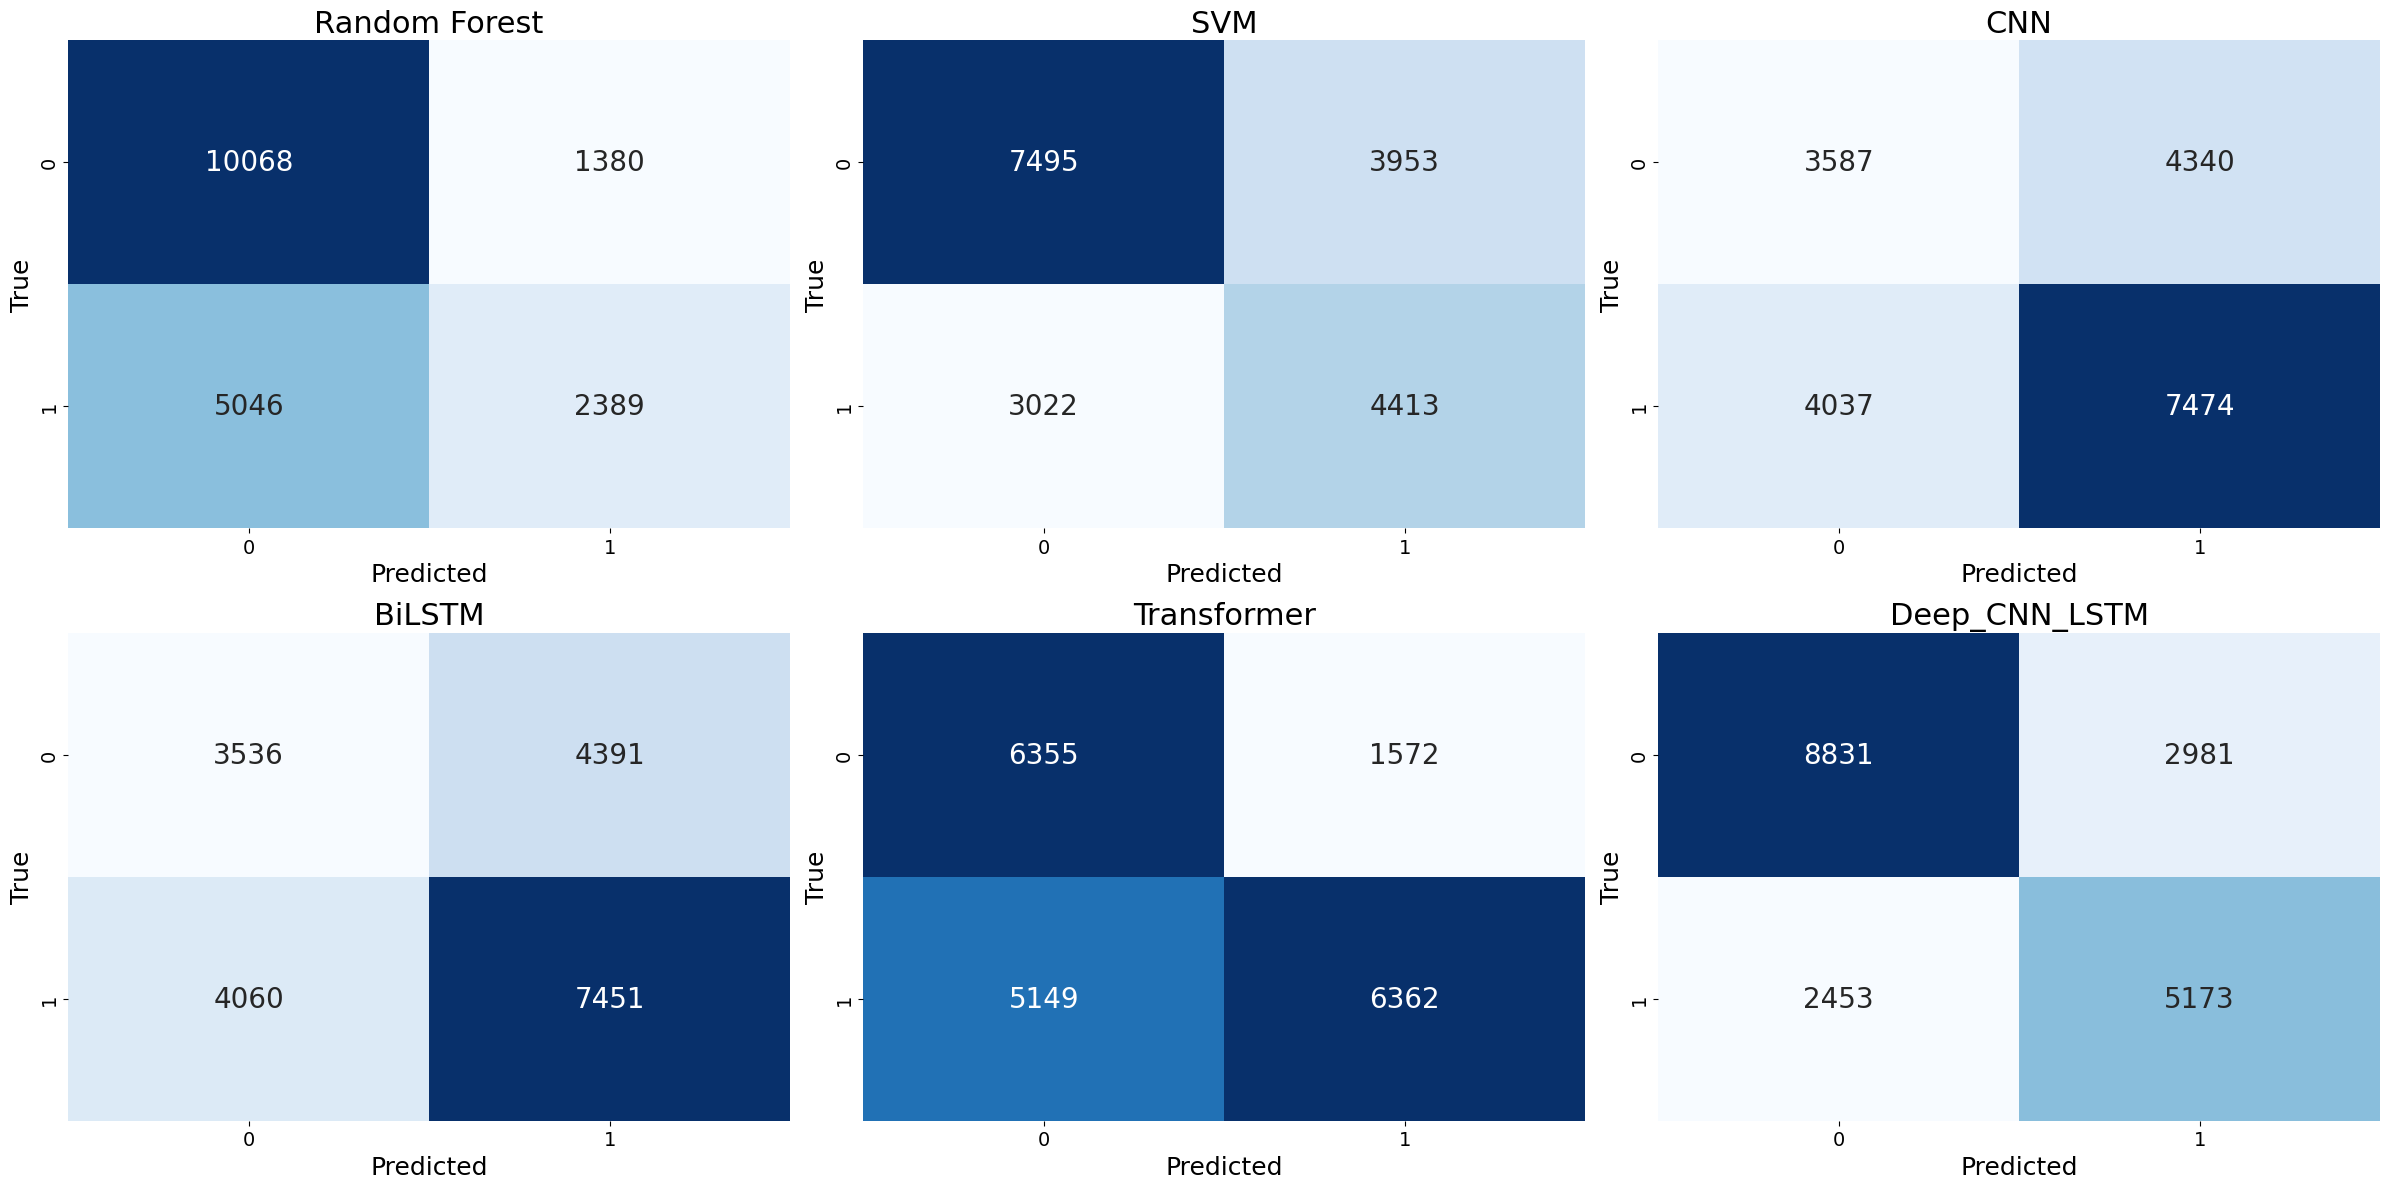

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define confusion matrices for all models
cm_data = {
    "Random Forest": np.array([[10068, 1380],
                               [5046, 2389]]),
    "SVM": np.array([[7495, 3953],
                     [3022, 4413]]),
    "CNN": np.array([[3587, 4340],
                     [4037, 7474]]),
    "BiLSTM": np.array([[3536, 4391],
                      [4060, 7451]]),
    "Transformer": np.array([[6355, 1572],
                             [5149, 6362]]),
    "Deep_CNN_LSTM": np.array([[ 8831, 2981 ],
                             [2453,5173 ] ])
}
# List of model names for plotting order
models = list(cm_data.keys())

# Set figure size according to number of models
fig, axes = plt.subplots(2, 3, figsize=(24, 12))  # 2 rows, 3 columns
axes = axes.flatten()

# Plot confusion matrices
for i, model in enumerate(models):
    sns.heatmap(cm_data[model], annot=True, fmt='d', ax=axes[i], cmap="Blues", cbar=False,
                annot_kws={"size":20})  # annotation font size
    axes[i].set_xlabel('Predicted', fontsize=18)
    axes[i].set_ylabel('True', fontsize=18)
    axes[i].set_title(model, fontsize=22)
    axes[i].tick_params(axis='x', labelsize=14)
    axes[i].tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.show() 
"""  [
          8339,
          3473
        ],
        [
          1860,
          5766
        ]"""

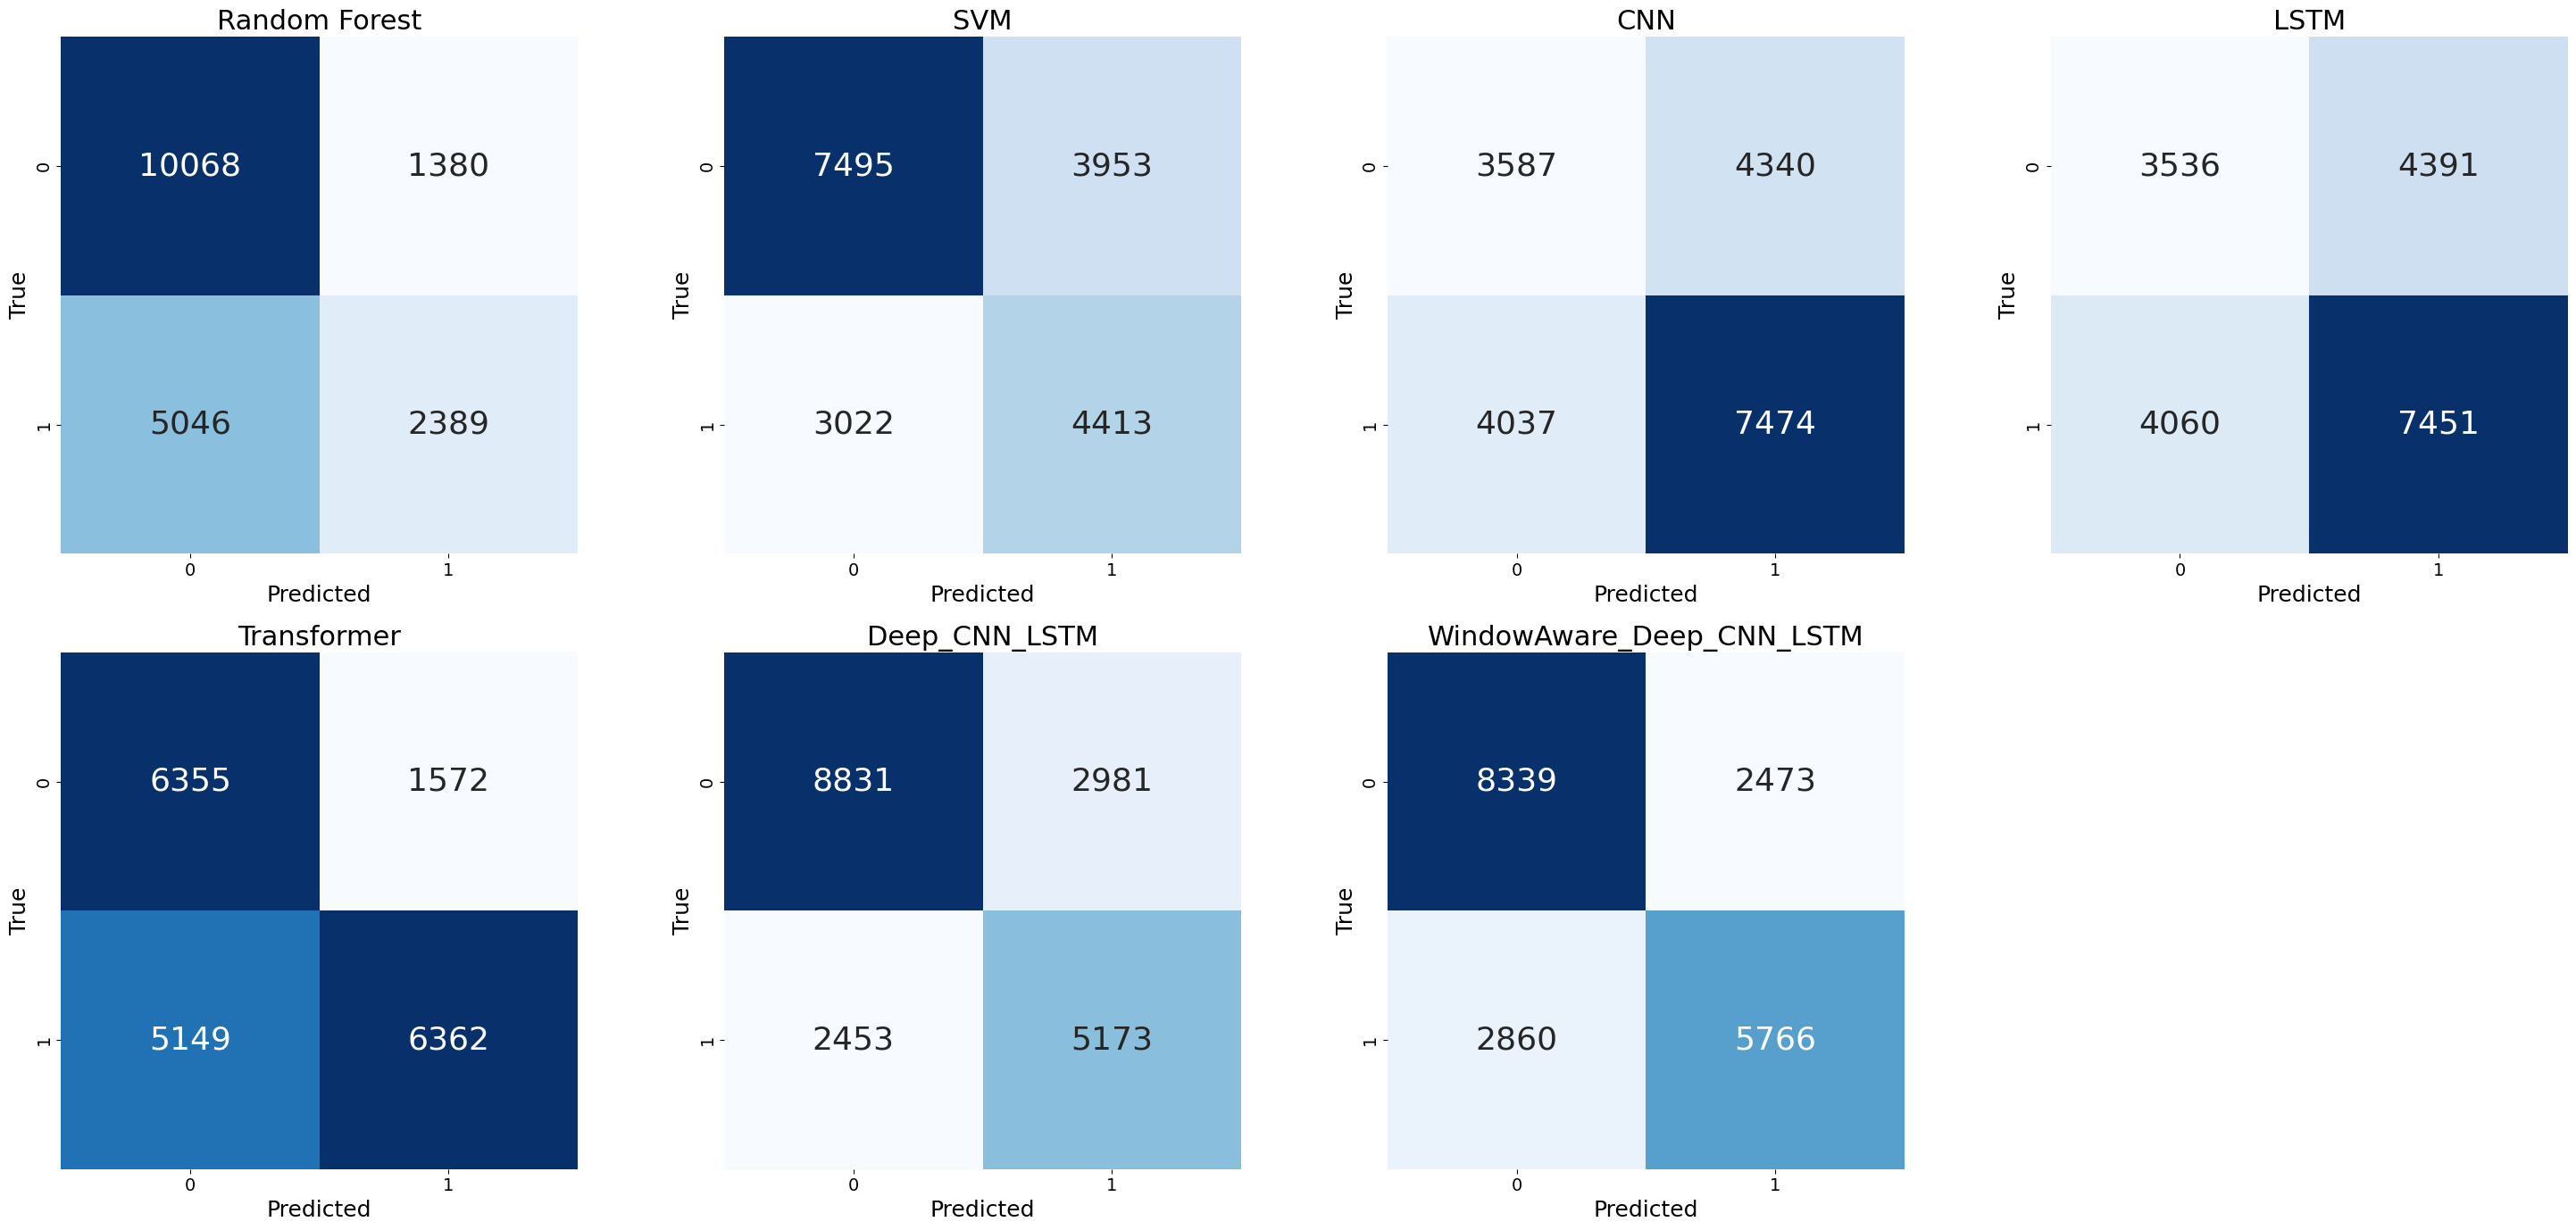

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define confusion matrices for all models
cm_data = {
    "Random Forest": np.array([[10068, 1380],
                               [5046, 2389]]),

    "SVM": np.array([[7495, 3953],
                     [3022, 4413]]),

    "CNN": np.array([[3587, 4340],
                     [4037, 7474]]),

    "LSTM": np.array([[3536, 4391],
                      [4060, 7451]]),

    "Transformer": np.array([[6355, 1572],
                             [5149, 6362]]),

    "Deep_CNN_LSTM": np.array([[8831, 2981],
                               [2453, 5173]])
}

# Add Window-Aware CNN-LSTM entry
cm_data["WindowAware_Deep_CNN_LSTM"] = np.array([
    [8339, 2473],
    [2860, 5766]
])

models = list(cm_data.keys())

# Layout: 4 models in row 1, 3 in row 2
rows = 2
cols = 4  # create 8 slots; last one will be deleted
fig, axes = plt.subplots(rows, cols, figsize=(30, 14))
axes = axes.flatten()

# Plot confusion matrices
for i, model in enumerate(models):
    sns.heatmap(cm_data[model], annot=True, fmt='d', ax=axes[i],
                cmap="Blues", cbar=False, annot_kws={"size": 26})

    axes[i].set_xlabel('Predicted', fontsize=18)
    axes[i].set_ylabel('True', fontsize=18)
    axes[i].set_title(model, fontsize=22)
    axes[i].tick_params(axis='x', labelsize=14)
    axes[i].tick_params(axis='y', labelsize=14)

    # Make each heatmap square
    axes[i].set_aspect("equal")

# Remove extra unused subplot (8th panel)
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()




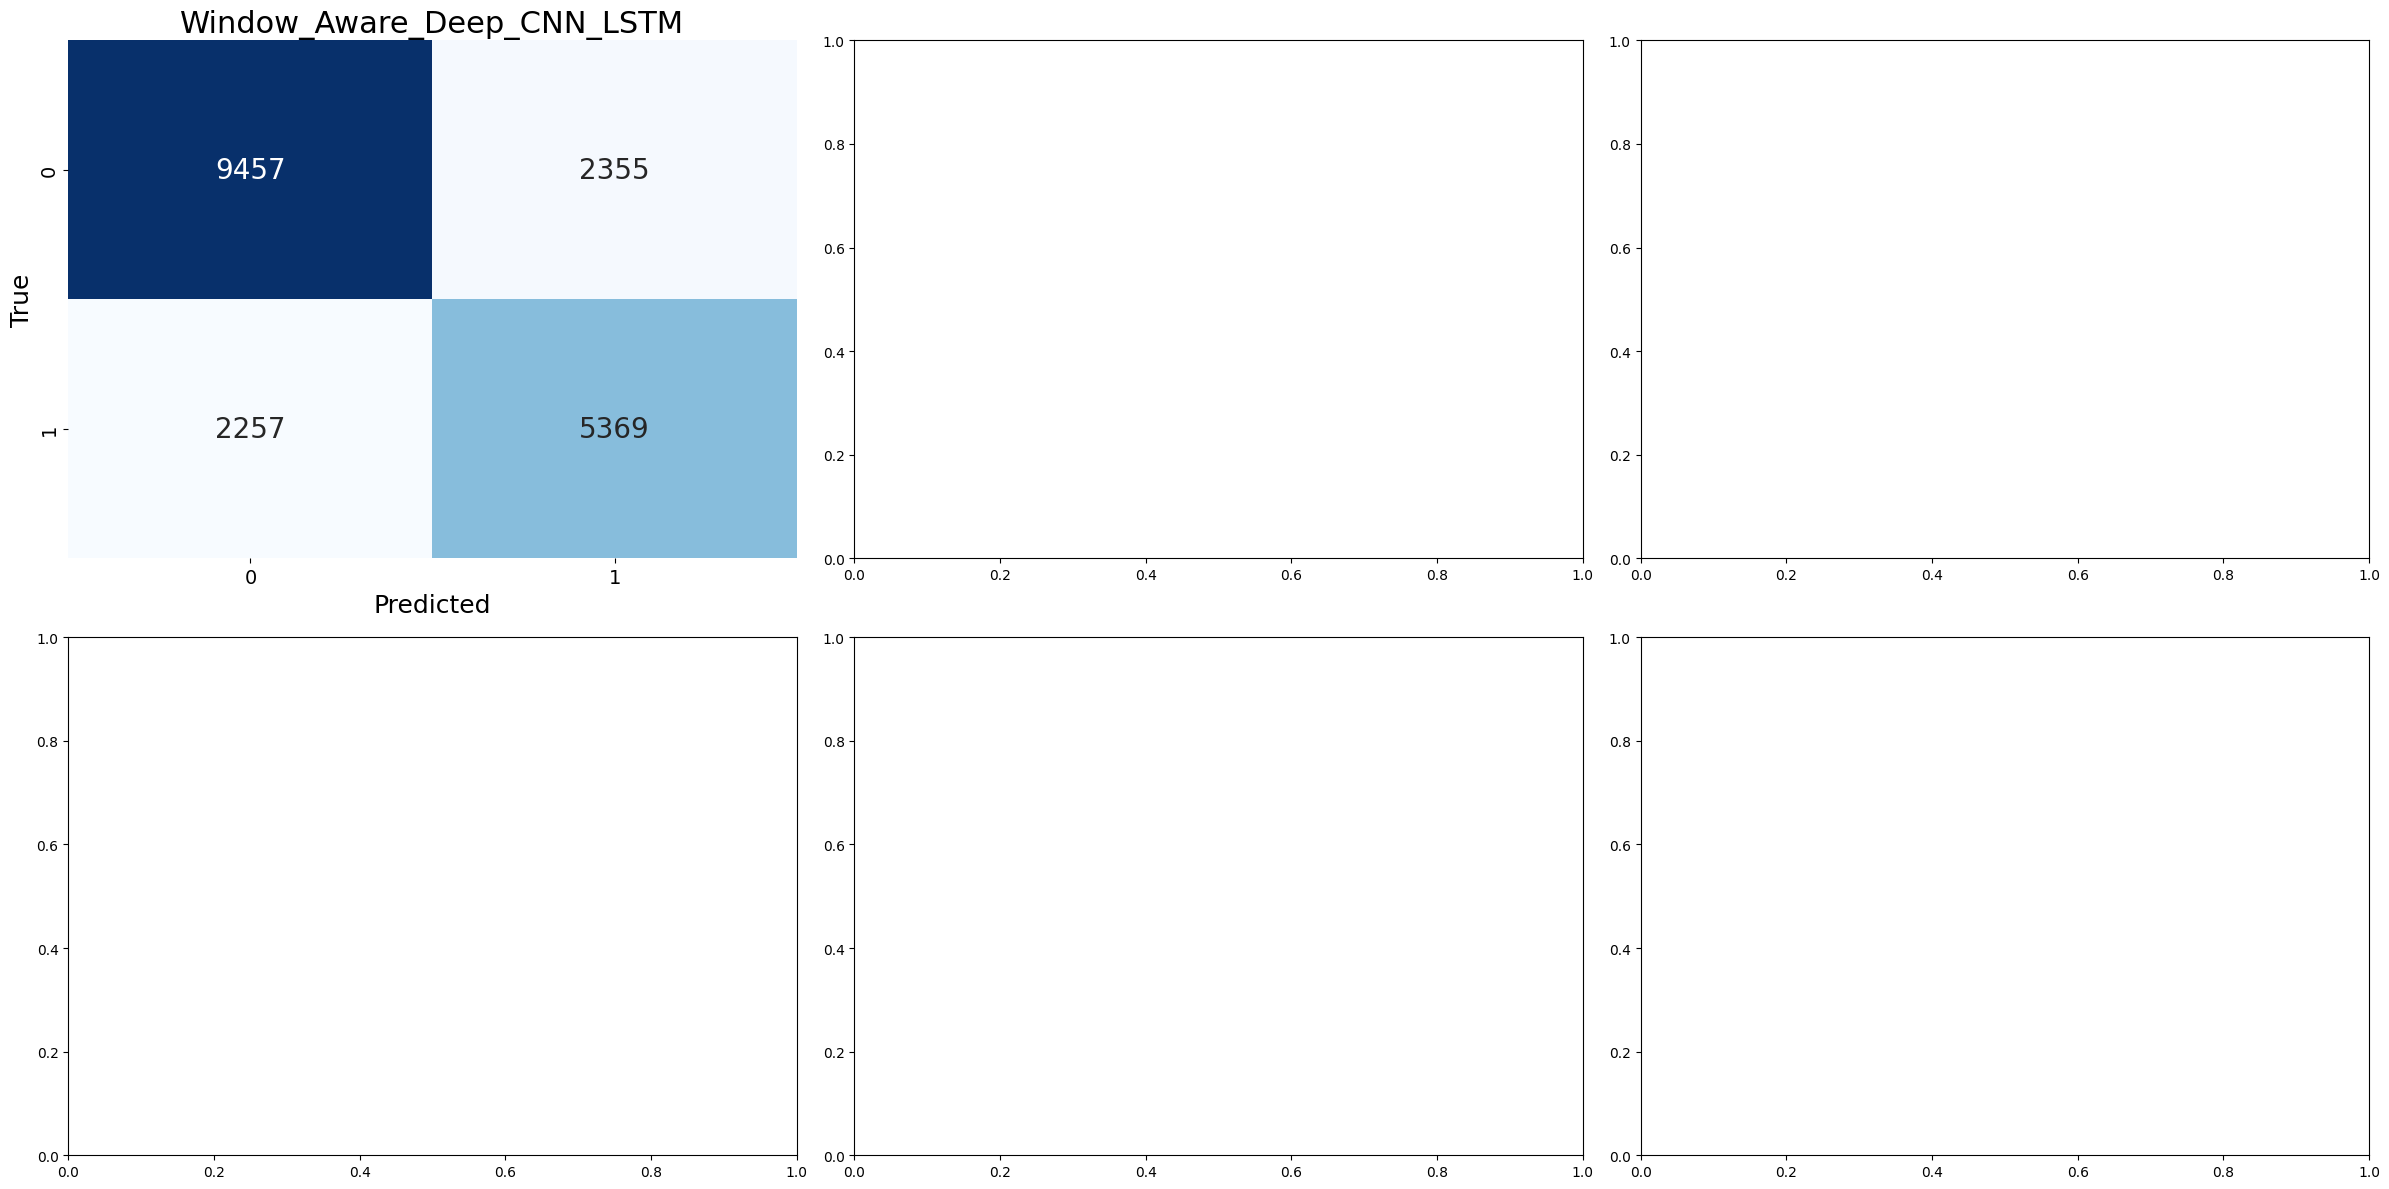

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define confusion matrices for all models
cm_data = {
    "Window_Aware_Deep_CNN_LSTM": np.array([[
          9457,
          2355 ],
         [
          2257,
          5369 ] ])
}
"""
    "Hybrid-CNN–BiLSTM": np.array([[5485, 2442],
                               [4477, 7034]]),
                               [
          9457,
          2355
        ],
        [
          2257,
          5369
        ]"""
# List of model names for plotting order
models = list(cm_data.keys())

# Set figure size according to number of models
fig, axes = plt.subplots(2, 3, figsize=(24, 12))  # 2 rows, 3 columns
axes = axes.flatten()

# Plot confusion matrices
for i, model in enumerate(models):
    sns.heatmap(cm_data[model], annot=True, fmt='d', ax=axes[i], cmap="Blues", cbar=False,
                annot_kws={"size":20})  # annotation font size
    axes[i].set_xlabel('Predicted', fontsize=18)
    axes[i].set_ylabel('True', fontsize=18)
    axes[i].set_title(model, fontsize=22)
    axes[i].tick_params(axis='x', labelsize=14)
    axes[i].tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.show()

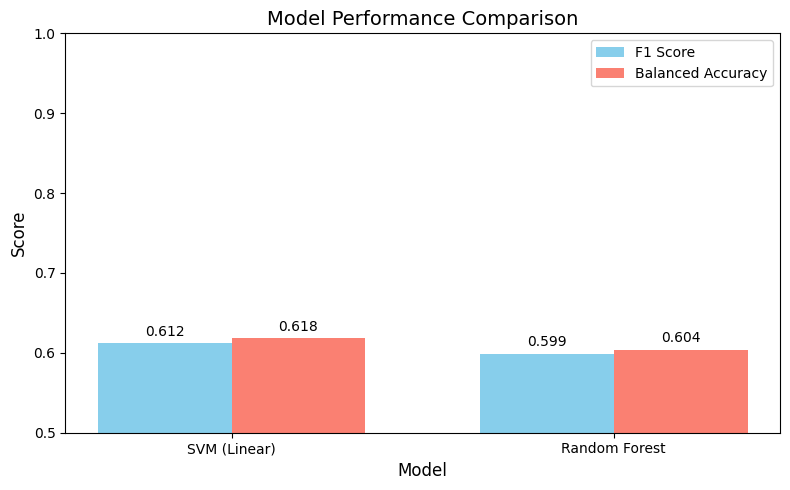

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['SVM (Linear)', 'Random Forest']

# Scores
macro_f1 = [0.612, 0.599]
balanced_acc = [0.618, 0.604]

# Set the width of the bars
bar_width = 0.35
index = np.arange(len(models))

# Create the bars
fig, ax = plt.subplots(figsize=(8,5))
bars1 = ax.bar(index, macro_f1, bar_width, label='F1 Score', color='skyblue')
bars2 = ax.bar(index + bar_width, balanced_acc, bar_width, label='Balanced Accuracy', color='salmon')

# Labels and title
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14)
ax.set_xticks(index + bar_width/2)
ax.set_xticklabels(models)
ax.set_ylim(0.5, 1, )

# Add value labels on top of bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

ax.legend()
plt.tight_layout()
plt.show()


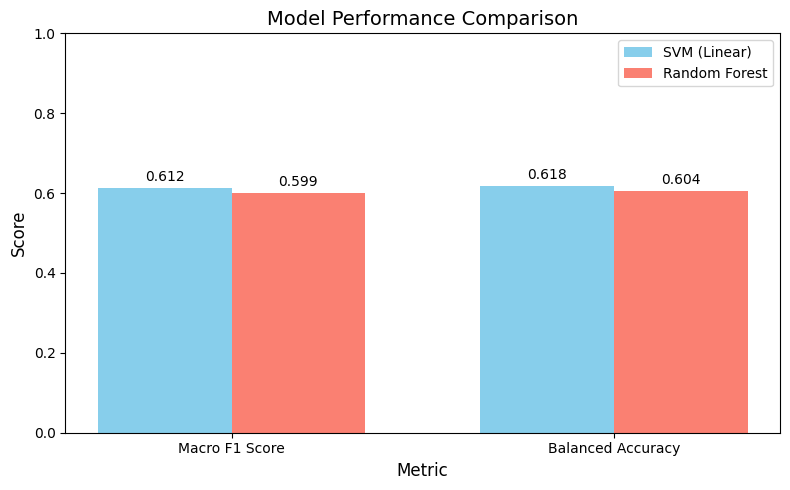

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics and models
metrics = ['Macro F1 Score', 'Balanced Accuracy']
models = ['SVM (Linear)', 'Random Forest']

# Scores for each model
scores = {
    'SVM (Linear)': [0.612, 0.618],
    'Random Forest': [0.599, 0.604]
}

# Bar width
bar_width = 0.35
index = np.arange(len(metrics))

# Plot bars
fig, ax = plt.subplots(figsize=(8,5))

bars_svm = ax.bar(index - bar_width/2, scores['SVM (Linear)'], bar_width, label='SVM (Linear)', color='skyblue')
bars_rf = ax.bar(index + bar_width/2, scores['Random Forest'], bar_width, label='Random Forest', color='salmon')

# Labels and title
ax.set_xlabel('Metric', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14)
ax.set_xticks(index)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)  # y-axis range

# Add value labels on top of bars
for bars in [bars_svm, bars_rf]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

ax.legend()
plt.tight_layout()
plt.show()


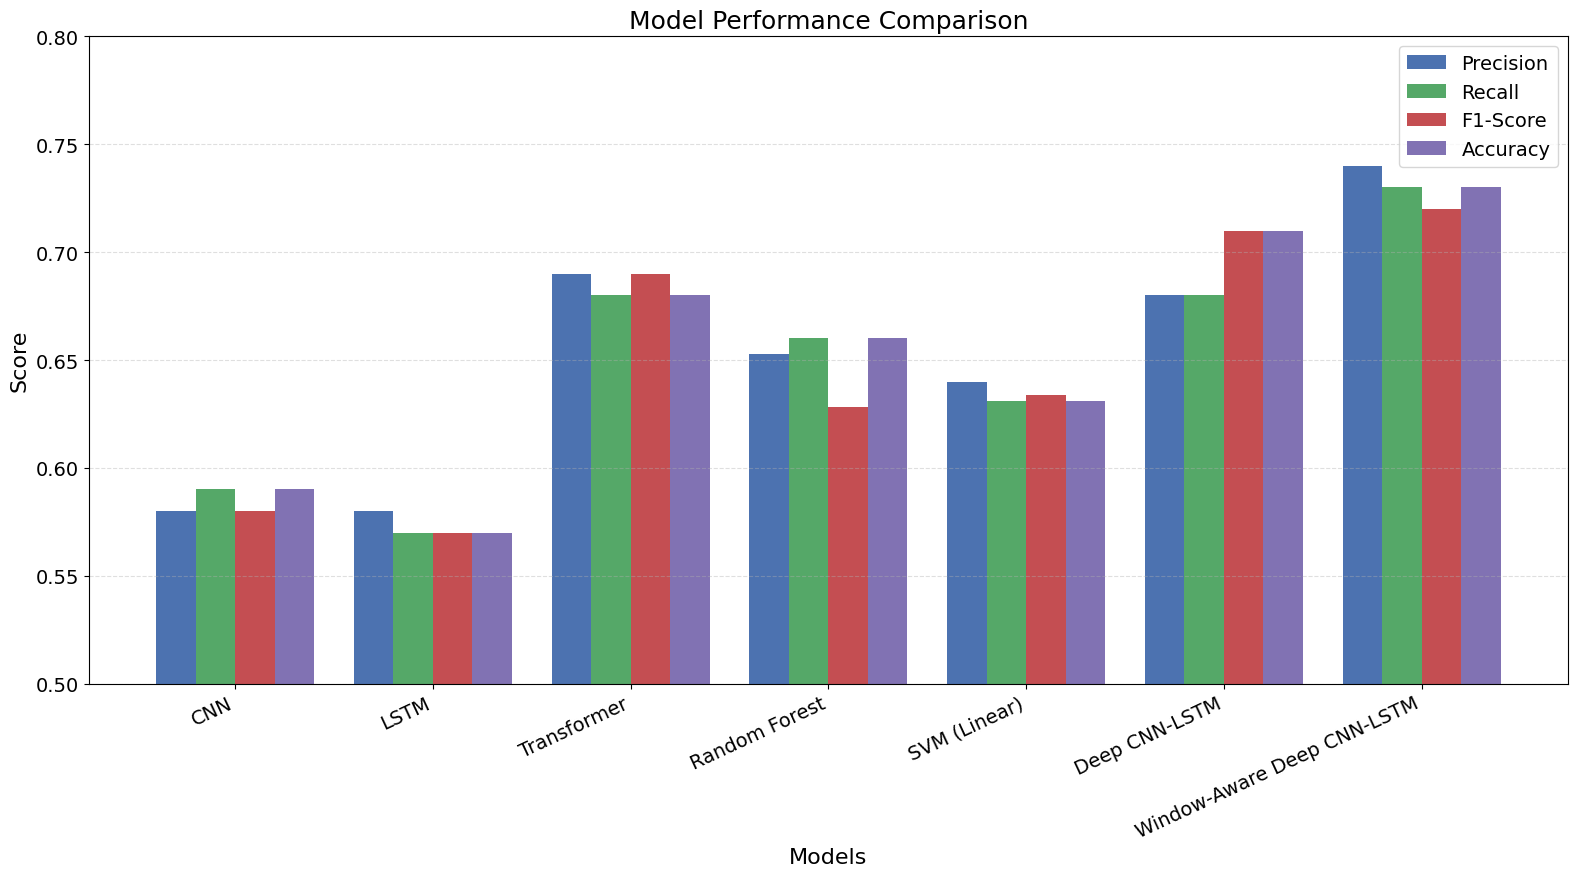

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = [
    "CNN", 
    "LSTM", 
    "Transformer", 
    "Random Forest", 
    "SVM (Linear)",
    "Deep CNN-LSTM",
    "Window-Aware Deep CNN-LSTM"
]
"""eep CNN–LSTM 0.680 0.680 0.710 0.713
Window-Aware Deep CNN–LSTM 0.740 0.730 0.728 0.731
"""
precision = [0.58, 0.58, 0.69, 0.653, 0.640, 0.68, 0.74]
recall    = [0.59, 0.57, 0.68, 0.660, 0.631, 0.68, 0.73]
f1_score  = [0.58, 0.57, 0.69, 0.628, 0.634, 0.71, 0.72]
accuracy  = [0.59, 0.57, 0.68, 0.660, 0.631, 0.71, 0.73]

# Plot setup
x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 14})

# Bars
plt.bar(x - 1.5*width, precision, width, label='Precision', color='#4C72B0')
plt.bar(x - 0.5*width, recall,    width, label='Recall', color='#55A868')
plt.bar(x + 0.5*width, f1_score,  width, label='F1-Score', color='#C44E52')
plt.bar(x + 1.5*width, accuracy,  width, label='Accuracy', color='#8172B3')

# Labels and styling
plt.xlabel("Models", fontsize=16)
plt.ylabel("Score", fontsize=16)
plt.title("Model Performance Comparison", fontsize=18)
plt.xticks(x, models, rotation=25, ha='right')
plt.ylim(0.5, 0.8)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(fontsize=14)
plt.tight_layout()
"""
# Annotate bars with values
for i in range(len(x)):
    for j, metric in enumerate([precision, recall, f1_score, accuracy]):
        plt.text(x[i] + (j-1.5)*width, metric[i]+0.005, f"{metric[i]:.2f}", 
                 ha='center', va='bottom', fontsize=10)"""

plt.show()


In [ ]:
"""
deep_cnn_lstm
confusion_matrix": [
        [
          8831,
          2981
        ],
        [
          2453,
          5173
        ]
        
window_aware_deep_cnn_lstm 
"confusion_matrix": [
        [
          9457,
          2355
        ],
        [
          2257,
          5369
        ]
"""